# Robust PCA Based Anomaly Detector

The goal is to detect which days the return were anomalous based on some sparse metric.  We should understand the anomalous behavior using several factos:
<ol>
    <li> Did S&amp;P 500 move because only large cap stocks moved?
    <li> Did a large number of S&amp;P 500 constituents move?
    <li> Given that markets are mean reverting, how long does this movement last?
</ol>

<p> There are several things to consider:
<ol>
    <li> What makes a S&amp;P 500 return anomalous? Is it an absolute/threshold value?      
    <li> Should we use the same threshold for each ticker or should we use a different ticker?
    <li> Given, markets are semi-efficient, especially large cap stocks should we use a moving average?
    <li> Should we use sector ETF with ARIMA type model or absolute value?
</ol>

In [1]:
import numpy as np
import os
import sys
import pandas as pd
from dateutil import parser
import scipy.sparse

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
import itertools

import datetime
import time
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import style

In [3]:
# pca_df = pd.read_csv(r"C:\phd\rpca\input\pca.csv") 
# pca_df.fillna(0, inplace=True)

# normal_mask = sp500_returns_df['Return'] > 0.03
# x = sp500_returns_df.loc[normal_mask]['Return']
# y = [0] * normal_mask.shape[0]
# z = [0] * normal_mask.shape[0]

In [4]:
import random

In [5]:
# x = [random.uniform(0, 1) for i in np.arange(20)]
# y = [random.uniform(0, 1) for i in np.arange(20)]
# # z = [random.uniform(-0.05, 0.05) for i in np.arange(20)]
# z = [0] * len(x)

In [6]:
# from matplotlib import pyplot
# from mpl_toolkits.mplot3d import Axes3D
# import random
# import matplotlib.lines as mlines
# # from colour import Color 

# fig = pyplot.figure()
# ax = Axes3D(fig)

# x = [random.uniform(0, 1) for i in np.arange(20)]
# y = [random.uniform(0, 1) for i in np.arange(20)]
# z = [0] * len(x)
# ax.scatter(x, y, z, color="blue")

# z_positive = [random.uniform(0.75, 0.95) for i in np.arange(4)]
# x = [random.uniform(0, 1) for i in np.arange(len(z_positive))]
# y = [random.uniform(0, 1) for i in np.arange(len(z_positive))]
# ax.scatter([0.2, 0.9, 0.6, 0.8], [0.2, 0.1, 0.6, 0.8], z_positive, color="green")
# ax.set_zlim(-1, 1)

# z_negative = [random.uniform(-0.75, -0.95) for i in np.arange(4)]
# x = [random.uniform(0, 1) for i in np.arange(len(z_negative))]
# y = [random.uniform(0, 1) for i in np.arange(len(z_negative))]
# ax.scatter([0.2, 0.4, 0.6, 0.8], [0.2, 0.4, 0.6, 0.8], z_negative, color="red")

# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# ax.w_xaxis.line.set_color((0.5, 0.5, 0.5, 0.0))
# # ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# # ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# ax.set_zlabel('Daily Returns')

# # lines
# y = np.linspace(0.0, 1.0, 100)
# z = [0] * len(y)
# x = [0] * len(y)
# ax.plot(x, y, z, color="magenta")

# x = np.linspace(0.0, 1.0, 100)
# z = [0] * len(x)
# y = [0] * len(x)
# ax.plot(x, y, z, color="magenta")

# x = np.linspace(0.0, 1.0, 100)
# z = [0] * len(x)
# y = [1] * len(x)
# ax.plot(x, y, z, color="magenta")

# y = np.linspace(0.0, 1.0, 100)
# z = [0] * len(y)
# x = [1] * len(y)
# ax.plot(x, y, z, color="magenta")

# # now make a mesh
# y = np.linspace(0, 1.0, 100)
# z = [0] * len(y)
# for x_val in np.linspace(0.1, 1.0, 10):
#     x = [x_val] * len(y)
#     ax.plot(x, y, z, '--', linewidth=0.25, color="#E8E8E8")

# x = np.linspace(0, 1.0, 100)
# z = [0] * len(y)
# for y_val in np.linspace(0.1, 1.0, 10):
#     y = [y_val] * len(x)
#     ax.plot(x, y, z, '--', linewidth=0.25, color="#E8E8E8")

# ax.set_facecolor('#E8E8E8')
# pyplot.show()

In [7]:
# fig = pyplot.figure()
# ax = Axes3D(fig)

# x = [np.linspace(0.0, 1.0, 25)]
# y = [np.linspace(0.2, 1.0, 25)]
# z = [0] * len(x)
# ax.scatter(x, y, z, color="blue")

# x = [np.linspace(0.0, 1.0, 25)]
# y = [np.linspace(0.2, 0.6, 25)]
# z = [0] * len(x)
# ax.scatter(x, y, z, color="red")

# x = [np.linspace(0.0, 0.6, 25)]
# y = [np.linspace(0.2, 1.0, 25)]
# z = [0] * len(x)
# ax.scatter(x, y, z, color="green")

# z_positive = [random.uniform(0.75, 0.95) for i in np.arange(4)]
# x = [random.uniform(0, 1) for i in np.arange(len(z_positive))]
# y = [random.uniform(0, 1) for i in np.arange(len(z_positive))]
# ax.scatter([0.2, 0.9, 0.6, 0.8], [0.2, 0.1, 0.6, 0.8], z_positive, color="green")
# ax.set_zlim(-1, 1)

# z_negative = [random.uniform(-0.75, -0.95) for i in np.arange(4)]
# x = [random.uniform(0, 1) for i in np.arange(len(z_negative))]
# y = [random.uniform(0, 1) for i in np.arange(len(z_negative))]
# ax.scatter([0.2, 0.4, 0.6, 0.8], [0.2, 0.4, 0.6, 0.8], z_negative, color="red")

# ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
# ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# ax.w_xaxis.line.set_color((0.5, 0.5, 0.5, 0.0))
# # ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# # ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

# ax.set_zlabel('Daily Returns')

# # lines
# y = np.linspace(0.0, 1.0, 100)
# z = [0] * len(y)
# x = [0] * len(y)
# ax.plot(x, y, z, color="magenta")

# x = np.linspace(0.0, 1.0, 100)
# z = [0] * len(x)
# y = [0] * len(x)
# ax.plot(x, y, z, color="magenta")

# x = np.linspace(0.0, 1.0, 100)
# z = [0] * len(x)
# y = [1] * len(x)
# ax.plot(x, y, z, color="magenta")

# y = np.linspace(0.0, 1.0, 100)
# z = [0] * len(y)
# x = [1] * len(y)
# ax.plot(x, y, z, color="magenta")

# # now make a mesh
# y = np.linspace(0, 1.0, 100)
# z = [0] * len(y)
# for x_val in np.linspace(0.1, 1.0, 10):
#     x = [x_val] * len(y)
#     ax.plot(x, y, z, '--', linewidth=0.25, color="#CCCCCC")

# x = np.linspace(0, 1.0, 100)
# z = [0] * len(y)
# for y_val in np.linspace(0.1, 1.0, 10):
#     y = [y_val] * len(x)
#     ax.plot(x, y, z, '--', linewidth=0.25, color="#CCCCCC")

# ax.set_facecolor('#E8E8E8')
# pyplot.show()

In [8]:
SP500_INDEX_LEVELS = r'C:\phd\rpca\input\prices\GSPC.csv'
SP500_ANOMALY_THRESHOLD = 0.015
TICKER_ANOMALY_THRESHOLD = 0.0001
BASE_OUTPUT_DIR = r'C:\phd\rpca\output'

#### FUNCTIONS TO LOAD S&P 500 DATA

In [251]:
def get_returns_daily_df(filename):
    """Load the data and calculate log return.  Remove the 
    first row because it will always be NaN."""
    df = pd.read_csv(filename) 
    df.set_index(df['Dates'], inplace=True)
    df.drop('Dates', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    return df_ret.iloc[1:]

def train_test_split(df, training_pct, validation_pct):
    training_set_end_idx = int(df.shape[0] * training_pct)
    validation_set_end_idx = int(df.shape[0] * (training_pct+ validation_pct))
    m_training = df[0:training_set_end_idx].copy()
    m_validation = df[training_set_end_idx:validation_set_end_idx].copy()
    m_test = df[validation_set_end_idx:].copy()
    return m_training, m_validation, m_test

"""
This method has been modified to account for polarity.  No winsorizing is done.  So if the 
entry is greater than 0, then it is positive.  If it is less than 0, it is untouched.
"""
def set_anomalies(x, upperThreshold, lowerThreshold, polarity=True):
    anomaly = 0
    if x >= upperThreshold:
        anomaly = 1
    elif x <= lowerThreshold:
        if polarity == True:
            anomaly = -1
        else:
            anomaly = 1
    else:
        anomaly = 0
    return anomaly
    
def get_sp500_anomalies(df, upperThreshold, lowerThreshold, polarity=True):
    df_anomalies = df.copy()
    df_anomalies.drop('Adj Close', axis=1, inplace=True)
    upperThreshold = np.percentile(df_anomalies['Return'], upperThreshold)
    lowerThreshold = np.percentile(df_anomalies['Return'], lowerThreshold)
    df_anomalies['Anomaly'] = df_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold,
                                                           polarity=polarity)
    return df_anomalies


def get_anomalies_dfs(df_training, df_val, df_test, upperThreshold, lowerThreshold, polarity=True):
    df_training_anomalies = df_training.copy()
    df_training_anomalies.drop('Adj Close', axis=1, inplace=True)
    upperThreshold = np.percentile(df_training_anomalies['Return'], upperThreshold)
    lowerThreshold = np.percentile(df_training_anomalies['Return'], lowerThreshold)
    df_training_anomalies['Anomaly'] = df_training_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold,
                                                           polarity=polarity)
    df_val_anomalies = df_val.copy()
    df_val_anomalies.drop('Adj Close', axis=1, inplace=True)
    df_val_anomalies['Anomaly'] = df_val_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold,
                                                           polarity=polarity)

    df_test_anomalies = df_test.copy()
    df_test_anomalies.drop('Adj Close', axis=1, inplace=True)
    df_test_anomalies['Anomaly'] = df_test_anomalies['Return'].apply(set_anomalies, 
                                                           upperThreshold=upperThreshold, 
                                                           lowerThreshold=lowerThreshold,
                                                           polarity=polarity)

    
    return df_training_anomalies, df_val_anomalies, df_test_anomalies

def load_matrices(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    
    u_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_U.dat')
    e_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_E.dat')
    vt_file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_VT.dat')
    
    U = np.load(u_file_path)
    E = np.load(e_file_path)
    VT = np.load(vt_file_path)
    
    return sparse_matrix, dense_matrix, U, E, VT

def load_sparse_matrix(root_dir, lam):
    file_path = get_full_path_2_save(root_dir, r'lambda_' + str(lam) + '_S.npz')
    sparse_matrix = scipy.sparse.load_npz(file_path)
    dense_matrix = sparse_matrix.todense()
    return dense_matrix

def get_full_path_2_save(root_dir, filename):
    full_path = os.path.join(root_dir, filename)    
    return full_path

def get_output_root_dir(dataset_type, input_type):
    output_root_dir = BASE_OUTPUT_DIR
    full_path = os.path.join(os.path.join(BASE_OUTPUT_DIR, input_type), dataset_type)    
    return full_path


"""
 Calculate the upper and lower cutoff points during training.  This cutoff is 
 based on the upper and lower percentile.  One this is decided, do no change it.
 Use the same cutoffs for valiation and testing.
"""
def get_sparse_df_from_matrix(S, sp500_anomalies, topPercentile, bottomPercentile, 
                              upperThreshold, lowerThreshold, isTraining=False):
    # set small entries to 0
    S[abs(S) < TICKER_ANOMALY_THRESHOLD] = 0        
    
    # -----------------------------------------
    # count positive
    # count negative
    # count 0's
    # calculate the ratio
    # ----------------------------------------
    P = (S > 0 ).sum(axis=1)
    N = (S < 0 ).sum(axis=1)
    Z = (S == 0).sum(axis=1)
    M = np.concatenate((P, N, Z), axis=1)
    
    S_df = pd.DataFrame(M, columns=['P', 'N', 'Z'])
    S_df.index = pd.to_datetime(sp500_anomalies.index)
    S_df['PNR'] = S_df['P'] / S_df['N']
    if isTraining:
        upperCutoff = np.percentile(S_df['PNR'], topPercentile)
        lowerCutoff = np.percentile(S_df['PNR'], bottomPercentile)
    else:
        upperCutoff = upperThreshold
        lowerCutoff = lowerThreshold
        
#     print("\t\t isTraining = {0}, upperCutoff = {1:.5f}, lowerCutoff = {2:.5f}".format(isTraining, upperCutoff, lowerCutoff))
    
    S_df['Anomaly'] = S_df['PNR'].apply(set_anomalies, upperThreshold=upperCutoff, lowerThreshold=lowerCutoff)
    S_df['upperCutoff'] = upperCutoff
    S_df['lowerCutoff'] = lowerCutoff
    return S_df, upperCutoff, lowerCutoff     

def get_sparse_dfs(input_type, lambda_multiplier, Y_training_anomalies, 
                   Y_validation_anomalies, Y_test_anomalies, topPercentile, bottomPercentile):
    output_root_dir = get_output_root_dir("training", input_type)
    S_training = load_sparse_matrix(output_root_dir, lambda_multiplier)
#     print("\tinput_type = {0:s}, now calling get_sparse_df_from_matrix with isTraining as True".format(input_type))
    S_training_df, upperCutoff, lowerCutoff = get_sparse_df_from_matrix(S_training, 
                                                                        Y_training_anomalies, 
                                                                        topPercentile,
                                                                        bottomPercentile,
                                                                        None, 
                                                                        None,
                                                                        True)
#     print("\tupperCutoff = {0:.5f}, lowerCutoff = {1:.5f}".format(upperCutoff, lowerCutoff))

    output_root_dir = get_output_root_dir("validation", input_type)
    S_validation = load_sparse_matrix(output_root_dir, lambda_multiplier)
#     print("\tinput_type = {0:s}, now calling get_sparse_df_from_matrix with isTraining as False; validation".format(input_type))
    S_validation_df, upperCutoff, lowerCutoff = get_sparse_df_from_matrix(S_validation, 
                                                      Y_validation_anomalies, 
                                                      None,
                                                      None,
                                                      upperCutoff, 
                                                      lowerCutoff, 
                                                      False)
#     print("\tupperCutoff = {0:.5f}, lowerCutoff = {1:.5f}".format(upperCutoff, lowerCutoff))
    
    output_root_dir = get_output_root_dir("test", input_type)
    S_test = load_sparse_matrix(output_root_dir, lambda_multiplier)
#     print("\tinput_type = {0:s}, now calling get_sparse_df_from_matrix with isTraining as False; test".format(input_type))
    S_test_df, upperCutoff, lowerCutoff = get_sparse_df_from_matrix(S_test, 
                                                Y_test_anomalies, 
                                                None, 
                                                None,
                                                upperCutoff,
                                                lowerCutoff,
                                                False)
#     print("\tupperCutoff = {0:.5f}, lowerCutoff = {1:.5f}".format(upperCutoff, lowerCutoff))
    return S_training_df, S_validation_df, S_test_df
        

def get_train_val_test(S_training_df, S_validation_df, S_test_df):
    X_train = S_training_df.iloc[4:,].copy().as_matrix()
    y_train = Y_training_anomalies.iloc[4:,1].copy().as_matrix()
    y_train = np.reshape(y_train,-1)

    X_val = S_validation_df.iloc[4:,].copy().as_matrix()
    y_val = Y_validation_anomalies.iloc[4:,1].copy().as_matrix()
    y_val = np.reshape(y_val,-1)

    X_test = S_test_df.iloc[4:,].copy().as_matrix()
    y_test = Y_test_anomalies.iloc[4:,1].copy().as_matrix()
    y_test = np.reshape(y_test,-1)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def get_metrics(y_train, y_pred):
    precision = f1_score(y_train, y_pred, average="macro")
    recall = recall_score(y_train, y_pred, average="macro")
    f1 = (2*precision*recall)/(precision+recall)
    return precision, recall, f1    

### Execute code from below

In [125]:
sp500_validation_df.head()

Return    Adj Close
Date                             
2013-10-09  0.000574  1656.400024
2013-10-10  0.021596  1692.560059
2013-10-11  0.006267  1703.199951
2013-10-14  0.004066  1710.140015
2013-10-15 -0.007089  1698.060059

In [10]:
# Decide what is an anomaly, by labeling days with 
# absolute return above a threshold as anomalies
sp500_df = pd.read_csv(SP500_INDEX_LEVELS)
sp500_df = sp500_df.set_index('Date')
sp500_df.index = pd.to_datetime(sp500_df.index)
df_ = sp500_df[['Adj Close']].copy()
df_returns = np.log(df_/df_.shift())
sp500_returns_df = df_returns.iloc[1:].copy()
sp500_returns_df.columns = ['Return']
sp500_returns_df['Adj Close'] = df_.loc[sp500_returns_df.index]['Adj Close']

# Split the data set and decide what is an anomaly
split_pct = 0.66
validation_pct = 0.17
# X_training_df, X_validation_df, X_test_df = train_test_split(constituents_returns_df, split_pct, validation_pct)
sp500_training_df, sp500_validation_df, sp500_test_df = train_test_split(sp500_returns_df, split_pct, validation_pct)

In [11]:
# We now have labeling to see if the day was anomalous or not
# upperThreshold = SP500_ANOMALY_THRESHOLD
# lowerThreshold = -1 * SP500_ANOMALY_THRESHOLD
# Y_training_anomalies = get_sp500_anomalies(sp500_training_df, upperThreshold, lowerThreshold)
# Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df, upperThreshold, lowerThreshold)
# Y_test_anomalies = get_sp500_anomalies(sp500_test_df, upperThreshold, lowerThreshold)

# print('-----------------------------------------------------------------------')
# print('Training S&P 500 instances = %d' % Y_training_anomalies.shape[0])
# print("\tDECREASE of > -2%% = %d" % np.sum(Y_training_anomalies['Anomaly'] < 0))
# print("\tNO CHANGE between -2%% and +2%% = %d" % np.sum(Y_training_anomalies['Anomaly'] == 0))
# print("\tINCREASE of > 2%% = %d" % np.sum(Y_training_anomalies['Anomaly'] > 0))

# print('-----------------------------------------------------------------------')
# print('Validation S&P 500 instances = %d' % Y_validation_anomalies.shape[0])
# print("\tDECREASE of > -2%% = %d" % np.sum(Y_validation_anomalies['Anomaly'] < 0))
# print("\tNO CHANGE between -2%% and +2%% = %d" % np.sum(Y_validation_anomalies['Anomaly'] == 0))
# print("\tINCREASE of > 2%% = %d" % np.sum(Y_validation_anomalies['Anomaly'] > 0))

# print('-----------------------------------------------------------------------')
# print('Test S&P 500 instances = %d' % Y_test_anomalies.shape[0])
# print("\tDECREASE of > -2%% = %d" % np.sum(Y_test_anomalies['Anomaly'] < 0))
# print("\tNO CHANGE between -2%% and +2%% = %d" % np.sum(Y_test_anomalies['Anomaly'] == 0))
# print("\tINCREASE of > 2%% = %d" % np.sum(Y_test_anomalies['Anomaly'] > 0))

### Exploratory Analysis of S&P Returns Distribution 

In [10]:
# normal_mask = Y_training_anomalies['Anomaly'] == 0
# anomaly_mask = ~normal_mask
# plt.scatter(Y_training_anomalies.index[normal_mask], Y_training_anomalies.loc[normal_mask]['Return'], color="green")
# plt.scatter(Y_training_anomalies.index[anomaly_mask], Y_training_anomalies.loc[anomaly_mask]['Return'], color="red")

In [12]:
# Bin the data frame by "Return" with 10 bins...
# bins = np.linspace(sp500_training_df.Return.min(), sp500_training_df.Return.max(), 10)
# groups = sp500_training_df.groupby(pd.cut(sp500_training_df.Return, bins))
# groups['Return'].hist()

In [13]:
# print(groups['Return'].count())

#### PLOT THE TARGET ALONG WITH S&P 500 INDEX LEVELS

In [14]:
def plot_sp500(training_df, validation_df, test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    axes[0].plot(training_df.index, training_df['Adj Close'])
    axes[0].set_title('Training S&P 500 Adj Close')
    axes[0].xaxis_date()
    axes[0].set_ylim(600, 3000)
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(validation_df.index, validation_df['Adj Close'])
    axes[1].set_title('Validation S&P 500 Adj Close')
    axes[1].xaxis_date()
    axes[1].set_ylim(600, 3000)
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(test_df.index, test_df['Adj Close'])
    axes[2].set_title('Test S&P 500 Adj Close')
    axes[2].xaxis_date()
    axes[2].set_ylim(600, 3000)
    axes[2].xaxis.set_major_formatter(date_format)
    
def plot_sp500_anomalies(training_df, validation_df, test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    
    normal_mask = training_df['Anomaly'] == 0
    axes[0].scatter(training_df.index[normal_mask], training_df.loc[normal_mask]['Return'], color="lightgray")
    
    positive_mask = training_df['Anomaly'] > 0
    axes[0].scatter(training_df.index[positive_mask], training_df.loc[positive_mask]['Return'], color="green")
    
    negative_mask = training_df['Anomaly'] < 0
    axes[0].scatter(training_df.index[negative_mask], training_df.loc[negative_mask]['Return'], color="red")
    
    axes[0].set_title('Training S&P 500 Anomalies')
    axes[0].set_ylim(-0.10, 0.10)
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    normal_mask = validation_df['Anomaly'] == 0
    axes[1].scatter(validation_df.index[normal_mask], validation_df.loc[normal_mask]['Return'], color="lightgray")

    positive_mask = validation_df['Anomaly'] > 0
    axes[1].scatter(validation_df.index[positive_mask], validation_df.loc[positive_mask]['Return'], color="green")
    
    negative_mask = validation_df['Anomaly'] < 0
    axes[1].scatter(validation_df.index[negative_mask], validation_df.loc[negative_mask]['Return'], color="red")    
    
    axes[1].set_title('Validation S&P 500 Anomalies')
    axes[1].set_ylim(-0.10, 0.10)
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    normal_mask = test_df['Anomaly'] == 0
    axes[2].scatter(test_df.index[normal_mask], test_df.loc[normal_mask]['Return'], color="lightgray")
    
    positive_mask = test_df['Anomaly'] > 0
    axes[2].scatter(test_df.index[positive_mask], test_df.loc[positive_mask]['Return'], color="green")

    negative_mask = test_df['Anomaly'] < 0
    axes[2].scatter(test_df.index[negative_mask], test_df.loc[negative_mask]['Return'], color="red")

    axes[2].set_title('Test S&P 500 Anomalies')
    axes[2].set_ylim(-0.10, 0.10)
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)

def plot_constituents(S_training_df, S_validation_df, S_test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    
    normal_mask = S_training_df['Anomaly'] == 0
    axes[0].scatter(S_training_df.index[normal_mask], S_training_df.loc[normal_mask]['PNR'], color="lightgray")
    
    positive_mask = S_training_df['Anomaly'] > 0
    axes[0].scatter(S_training_df.index[positive_mask], S_training_df.loc[positive_mask]['PNR'], color="green")

    negative_mask = S_training_df['Anomaly'] < 0
    axes[0].scatter(S_training_df.index[negative_mask], S_training_df.loc[negative_mask]['PNR'], color="red")
    
    axes[0].set_title('Training Constituents Anomalies')
    axes[0].set_ylim(0.5, 2)
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    #--------------------------------------------------------------------------------------------------------------
    normal_mask = S_validation_df['Anomaly'] == 0
    axes[1].scatter(S_validation_df.index[normal_mask], S_validation_df.loc[normal_mask]['PNR'], color="lightgray")
    
    positive_mask = S_validation_df['Anomaly'] > 0
    axes[1].scatter(S_validation_df.index[positive_mask], S_validation_df.loc[positive_mask]['PNR'], color="green")

    negative_mask = S_validation_df['Anomaly'] < 0
    axes[1].scatter(S_validation_df.index[negative_mask], S_validation_df.loc[negative_mask]['PNR'], color="red")

    axes[1].set_title('Validation Constituents Anomalies')
    axes[1].set_ylim(0.5, 2)
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    # -----------------------------------------------------------------------------------------------------------
    normal_mask = S_test_df['Anomaly'] == 0
    axes[2].scatter(S_test_df.index[normal_mask], S_test_df.loc[normal_mask]['PNR'], color="lightgray")
    
    positive_mask = S_test_df['Anomaly'] > 0
    axes[2].scatter(S_test_df.index[positive_mask], S_test_df.loc[positive_mask]['PNR'], color="green")

    negative_mask = S_test_df['Anomaly'] < 0
    axes[2].scatter(S_test_df.index[negative_mask], S_test_df.loc[negative_mask]['PNR'], color="red")

    axes[2].set_title('Test Constituents Anomalies')
    axes[2].set_ylim(0.5, 2)
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)
    
    
    
def plot_nnz(S_training_df, S_validation_df, S_test_df):
    fig, axes = plt.subplots(ncols=3, figsize = (20, 6))
    
    axes[0].plot(S_training_df.index, S_training_df['NNZ'])    
    axes[0].set_title('Training Sparse NNZ')
    axes[0].set_ylim(0, 400)
    axes[0].xaxis_date()
    date_format = mdates.DateFormatter('%m/%y')
    axes[0].xaxis.set_major_formatter(date_format)

    axes[1].plot(S_validation_df.index, S_validation_df['NNZ'])    
    axes[1].set_title('Validation S&P 500 Anomalies')
    axes[1].set_ylim(0, 400)
    axes[1].xaxis_date()
    axes[1].xaxis.set_major_formatter(date_format)

    axes[2].plot(S_test_df.index, S_test_df['NNZ'])    
    axes[2].set_title('Test S&P 500 Anomalies')
    axes[2].set_ylim(0, 400)
    axes[2].xaxis_date()
    axes[2].xaxis.set_major_formatter(date_format)    
    
    

### PLOT OF RETUNRS FOR A LAMBDA

In [14]:
some_lambda_multiplier = 1
topPercentile = 95
bottomPercentile = 5
Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile)
Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile)
Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile)

S_training_df, S_validation_df, S_test_df = get_sparse_dfs("returns", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies,
                                                            topPercentile, 
                                                            bottomPercentile)

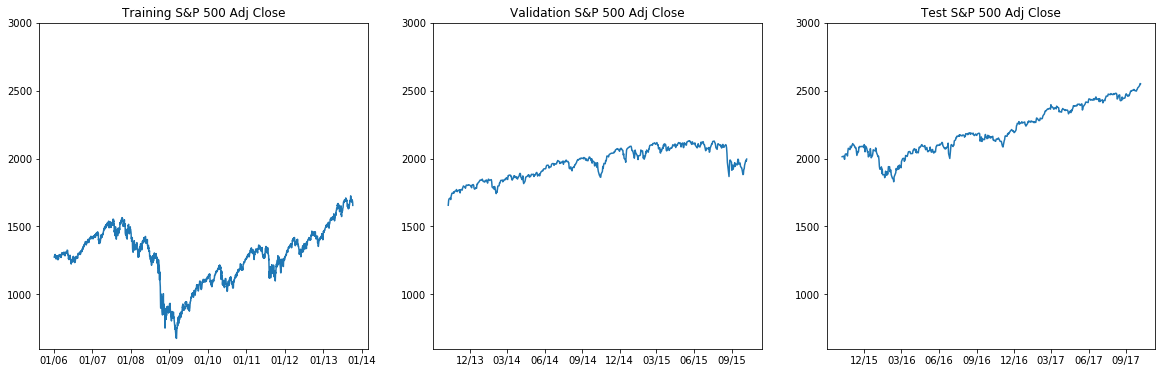

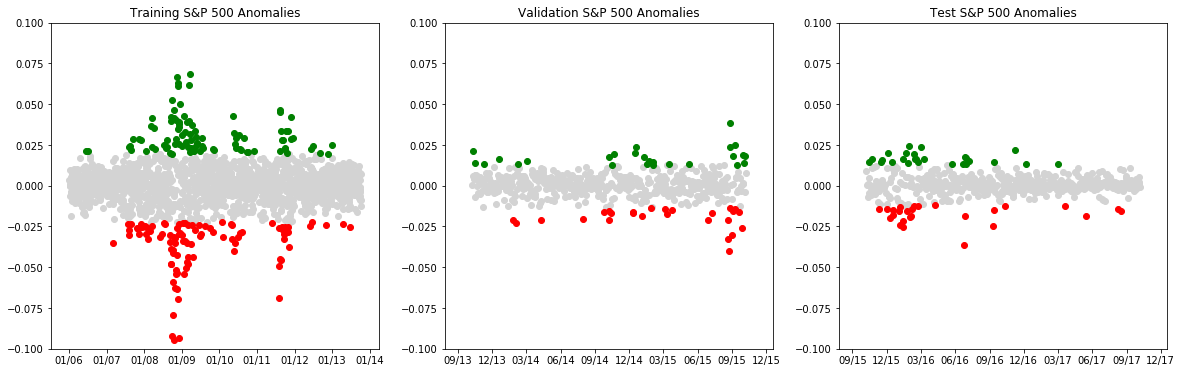

In [15]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
plot_constituents(S_training_df, S_validation_df, S_test_df)

Text(0,0.5,'S&P 500 Adj Close')

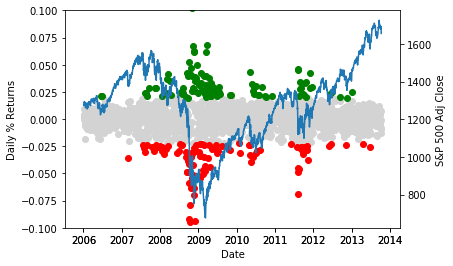

In [27]:
fig, axes1 = plt.subplots(ncols=1)

normal_mask = Y_training_anomalies['Anomaly'] == 0
axes1.scatter(Y_training_anomalies.index[normal_mask], Y_training_anomalies.loc[normal_mask]['Return'], color="lightgray")

positive_mask = Y_training_anomalies['Anomaly'] > 0
axes1.scatter(Y_training_anomalies.index[positive_mask], Y_training_anomalies.loc[positive_mask]['Return'], color="green")

negative_mask = Y_training_anomalies['Anomaly'] < 0
axes1.scatter(Y_training_anomalies.index[negative_mask], Y_training_anomalies.loc[negative_mask]['Return'], color="red")

# axes1.set_title('S&P 500 anomalies')
axes1.set_ylim(-0.10, 0.10)
axes1.xaxis_date()
date_format = mdates.DateFormatter('%m/%y')
axes1.xaxis.set_major_formatter(date_format)
axes1.set_ylabel("Daily % Returns")
axes1.set_xlabel("Date")

axes2 = fig.add_subplot(111, sharex=axes1, frameon=False)
axes2.plot(sp500_training_df.index, sp500_training_df['Adj Close'])
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel("S&P 500 Adj Close")
# axes[0].xaxis_date()
# axes[0].set_ylim(600, 3000)
#     date_format = mdates.DateFormatter('%m/%y')
#     axes[0].xaxis.set_major_formatter(date_format)


In [28]:
fig, axes1 = plt.subplots(ncols=1)
    
normal_mask = S_training_df['Anomaly'] == 0
axes1.scatter(S_training_df.index[normal_mask], S_training_df.loc[normal_mask]['PNR'], color="lightgray")
    
positive_mask = S_training_df['Anomaly'] > 0
axes1.scatter(S_training_df.index[positive_mask], S_training_df.loc[positive_mask]['PNR'], color="green")

negative_mask = S_training_df['Anomaly'] < 0
axes1.scatter(S_training_df.index[negative_mask], S_training_df.loc[negative_mask]['PNR'], color="red")

# axes.set_title('Training Constituents Anomalies')
axes1.set_ylim(0.5, 2)
axes1.xaxis_date()
date_format = mdates.DateFormatter('%m/%y')
axes1.xaxis.set_major_formatter(date_format)

axes2 = fig.add_subplot(111, sharex=axes1, frameon=False)
axes2.plot(sp500_training_df.index, sp500_training_df['Adj Close'])
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel("S&P 500 Adj Close")


Text(0,0.5,'S&P 500 Adj Close')

#### $1^{ST}$ ORDER INPUT - RETURNS - DETECTING ANOMALIES

In [16]:
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

#### ALGORITHM - CREATES RETURNS RESULT DATAFRAME 

#### Plot Confusion Matrix 

In [215]:
# class_names = [-1, 0, 1]

# # Compute confusion matrix
# cnf_matrix = confusion_matrix(y_train, y_training_pred)
# np.set_printoptions(precision=2)

# # Plot non-normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names,
#                       title='Confusion matrix, without normalization')

# # Plot normalized confusion matrix
# plt.figure()
# plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')


### Random Forest to Predict If Tomorrow Is Anomalous

In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_recall_fscore_support
from random import randint

Let us prepare, y_train, y_val, and y_test

In [60]:
topPercentile = 95
bottomPercentile = 5
Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile)
Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile)
Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile)

In [98]:
S.shape


(504, 549)

In [126]:
# lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
#             0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
#             6, 7, 8, 9, 10]

# lam_list = [0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33]

lam_list = [0.1429]

prediction_result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                              'Test Accuracy', 'Test Precision', 
                                              'Test Recall', 'Test F1', 'Test F2', 'Test ROC AUC Score'])

row_idx = 0

for percentile in np.arange(5,49):
    topPercentile = 100 - percentile
    bottomPercentile = percentile
    
    # let us ignore polarity for now, so pass False
    Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile, False)
    Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile, False)
    Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile, False)
    
    y_train = Y_training_anomalies.iloc[2:,]['Anomaly']
    y_val = Y_validation_anomalies.iloc[2:,]['Anomaly']
    y_test = Y_test_anomalies.iloc[2:,]['Anomaly']

    print("Processing percentile: {0:d}".format(percentile))

    for lambda_multiplier in lam_list:
        print("\tLambda Multiplier: {0:.4f}".format(lambda_multiplier))
        output_root_dir = get_output_root_dir("training", "returns")
        S = load_sparse_matrix(output_root_dir, lambda_multiplier)
        X_train = S[:-2,]

        return_threshold = 0.003
        X_train[abs(X_train) < return_threshold] = 0 
        
        output_root_dir = get_output_root_dir("validation", "returns")
        S = load_sparse_matrix(output_root_dir, lambda_multiplier)
        X_val = S[:-2,]
        X_val[abs(X_val) < return_threshold] = 0 

        output_root_dir = get_output_root_dir("test", "returns")
        S = load_sparse_matrix(output_root_dir, lambda_multiplier)
        X_test = S[:-2,]
        X_test[abs(X_test) < return_threshold] = 0 
    
        # loop invaraint
        clf = RandomForestClassifier()
        clf.fit(X_train, y_train)
        
        pred_y = clf.predict(X_train)
#         print("\t\t Unique value in training: {0}".format(np.unique(pred_y)))
#         print("\t\t Training Accuracy: {0}".format(accuracy_score(y_train, pred_y)))
        
#         precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, pred_y, beta=1.0)
#         _, _recall, f2_score, _ = precision_recall_fscore_support(y_train, pred_y, beta=2.0)
#         print("\t\t Training Precision: {0}".format(precision))
#         print("\t\t Training Recall: {0}".format(recall))
#         print("\t\t Training f1 score: {0}".format(f1_score))
#         print("\t\t Training f2 score: {0}".format(f2_score))

        # What about AUROC?
#         prob_y_4 = clf.predict_proba(X_train)
#         prob_y_4 = [p[1] for p in prob_y_4]
#         print("\t\t Training ROC_AUC_SCORE: {0}".format(roc_auc_score(y_train, prob_y_4)))
        
        pred_y_test = clf.predict(X_test)
        print("\t\t Unique values in TEST: {0}".format(np.unique( pred_y_test )))
        test_accuracy = accuracy_score(y_test, pred_y_test)
        print("\t\t TEST Accuracy: {0}".format(test_accuracy))

        test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=1.0, average="macro")
        _, _, test_f2_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=2.0, average="macro")
        print("\t\t TEST Precision: {0}".format(test_precision))
        print("\t\t TEST Recall: {0}".format(test_recall))
        print("\t\t TEST f1 score: {0}".format(test_f1_score))
        print("\t\t TEST f2 score: {0}".format(test_f2_score))
        
        prob_y_test = clf.predict_proba(X_test)
        prob_y_test = [p[1] for p in prob_y_test]
        test_roc = roc_auc_score(y_test, prob_y_test)
        print("\t\t TEST ROC_AUC_SCORE: {0}".format(test_roc))

        prediction_result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                                  test_accuracy, test_precision, test_recall, test_f1_score, test_f2_score, test_roc]
    
        row_idx = row_idx + 1        

Processing percentile: 5
	Lambda Multiplier: 0.1429
		 Unique values in TEST: [0 1]
		 TEST Accuracy: 0.8944223107569721
		 TEST Precision: 0.4481037924151697
		 TEST Recall: 0.4988888888888889
		 TEST f1 score: 0.47213459516298634
		 TEST f2 score: 0.48783137766188617
		 TEST ROC_AUC_SCORE: 0.6677777777777777
Processing percentile: 6
	Lambda Multiplier: 0.1429
		 Unique values in TEST: [0 1]
		 TEST Accuracy: 0.8804780876494024
		 TEST Precision: 0.7748655913978495
		 TEST Recall: 0.5299853372434018
		 TEST f1 score: 0.5267722473604827
		 TEST f2 score: 0.5247424191656894
		 TEST ROC_AUC_SCORE: 0.6538489736070381
Processing percentile: 7
	Lambda Multiplier: 0.1429
		 Unique values in TEST: [0 1]
		 TEST Accuracy: 0.850597609561753
		 TEST Precision: 0.6322381930184805
		 TEST Recall: 0.5312015503875969
		 TEST f1 score: 0.528071296957846
		 TEST f2 score: 0.5263966586962275
		 TEST ROC_AUC_SCORE: 0.6867732558139534
Processing percentile: 8
	Lambda Multiplier: 0.1429
		 Unique values i

		 Unique values in TEST: [0 1]
		 TEST Accuracy: 0.5438247011952191
		 TEST Precision: 0.5035719239839089
		 TEST Recall: 0.5035455499905337
		 TEST f1 score: 0.5035391159767658
		 TEST f2 score: 0.5035382952201299
		 TEST ROC_AUC_SCORE: 0.5161787232577751
Processing percentile: 33
	Lambda Multiplier: 0.1429
		 Unique values in TEST: [0 1]
		 TEST Accuracy: 0.5677290836653387
		 TEST Precision: 0.5042992424242425
		 TEST Recall: 0.504010529849296
		 TEST f1 score: 0.5031357899682087
		 TEST f2 score: 0.5034289990442014
		 TEST ROC_AUC_SCORE: 0.5223935972862671
Processing percentile: 34
	Lambda Multiplier: 0.1429
		 Unique values in TEST: [0 1]
		 TEST Accuracy: 0.5816733067729084
		 TEST Precision: 0.5167500962649211
		 TEST Recall: 0.5167500962649211
		 TEST f1 score: 0.5167500962649211
		 TEST f2 score: 0.5167500962649211
		 TEST ROC_AUC_SCORE: 0.54630801107505
Processing percentile: 35
	Lambda Multiplier: 0.1429
		 Unique values in TEST: [0 1]
		 TEST Accuracy: 0.6314741035856574
	

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [127]:
prediction_result_df.to_csv(r"C:\phd\rpca\debug\prediction_returns_result_threshold_003_lag2.csv")

In [99]:
# predict ahead
days_ahead = 1
y_train = Y_training_anomalies.iloc[days_ahead:,]['Anomaly']
y_val = Y_validation_anomalies.iloc[days_ahead:,]['Anomaly']
y_test = Y_test_anomalies.iloc[days_ahead:,]['Anomaly']

# y_train = label_binarize(y_train, classes=[-1, 0, 1])
# y_val= label_binarize(y_val, classes=[-1, 0, 1])
# y_test = label_binarize(y_test, classes=[-1, 0, 1])

some_lambda_multiplier = 1
output_root_dir = get_output_root_dir("training", "returns")
S = load_sparse_matrix(output_root_dir, some_lambda_multiplier)
X_train = S[:-days_ahead,]

output_root_dir = get_output_root_dir("validation", "returns")
S = load_sparse_matrix(output_root_dir, some_lambda_multiplier)
X_val = S[:-days_ahead,]

output_root_dir = get_output_root_dir("test", "returns")
S = load_sparse_matrix(output_root_dir, some_lambda_multiplier)
X_test = S[:-days_ahead,]

In [105]:
total_elements = X_train.shape[0]*X_train.shape[1]
nnz = np.count_nonzero(X_train)
pct = nnz/total_elements
print("Total: {0}, NNZ: {1}, %NNZ: {2}".format(total_elements, nnz, pct))

S[abs(S) < TICKER_ANOMALY_THRESHOLD] = 0        

Total: 1072197, NNZ: 1012201, %NNZ: 0.9440438650733027


In [116]:
S = X_train.copy()
return_threshold = 0.003
S[abs(S) < return_threshold] = 0 
total_elements = S.shape[0]*S.shape[1]
nnz = np.count_nonzero(S)
pct = nnz/total_elements
print("Total: {0}, NNZ: {1}, %NNZ: {2}".format(total_elements, nnz, pct))

Total: 1072197, NNZ: 566915, %NNZ: 0.5287414532963625


In [72]:
# Train model
clf.fit(X_train, y_train)

# Predict on training set
pred_y_4 = clf.predict(X_train)
 
# Is our model still predicting just one class?
print("Unique value in training: {0}".format(np.unique( pred_y_4 )))

Unique value in training: [0 1]


In [63]:
# How's our accuracy?
print( accuracy_score(y_train, pred_y_4) )

pred_y_test = clf.predict(X_test)
print( np.unique( pred_y_test ))
print( accuracy_score(y_test, pred_y_test))

0.9918032786885246
[0]
0.896414342629482


In [44]:
# What about AUROC?
prob_y_4 = clf.predict_proba(X_train)
prob_y_4 = [p[1] for p in prob_y_4]
print( roc_auc_score(y_train, prob_y_4) )

ValueError: multiclass format is not supported

### Simulation for Returns 

In [232]:
input_types = ["returns"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

row_idx = 0

result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                   'Training Precision', 'Training Recall', 'Training F1',
                                  'Validation Precision', 'Validation Recall', 'Validation F1',
                                  'Test Precision', 'Test Recall', 'Test F1'])

for percentile in np.arange(1,11):
    topPercentile = 100 - percentile
    bottomPercentile = percentile
    Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile)
    Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile)
    Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile)

    for input_type in input_types:
        print("-----------------------------------------------------------------------------")
        print("%s" % input_type)

        for lambda_multiplier in lam_list:
            print("Processing lambda = {0:.5f}, topPercentile = {1:d}%, bottomPercentile={2:d}%".format(lambda_multiplier, topPercentile, bottomPercentile))
            S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                       lambda_multiplier, 
                                                                       Y_training_anomalies, 
                                                                       Y_validation_anomalies, 
                                                                       Y_test_anomalies,
                                                                       topPercentile, 
                                                                       bottomPercentile)
            
            X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                                S_validation_df.copy(), 
                                                                                S_test_df.copy())        

            training_precision, training_recall, training_f1 = get_metrics(y_train, X_train[:,4])
            val_precision, val_recall, val_f1 = get_metrics(y_val, X_val[:,4])
            test_precision, test_recall, test_f1 = get_metrics(y_test, X_test[:,4])

            result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                                      training_precision, training_recall, training_f1, 
                                      val_precision, val_recall, val_f1, 
                                      test_precision, test_recall, test_f1]
            row_idx = row_idx + 1

# save the returns result data frame
result_df.to_csv(r"C:\phd\rpca\debug\returns_polarity_df.csv")

-----------------------------------------------------------------------------
returns
Processing lambda = 0.05000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05260, topPercentile = 99%, bottomPercentile=1%


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Processing lambda = 0.05560, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05880, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06250, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07140, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07690, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.08330, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.09090, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.10000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.11110, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.12500, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.14290, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.16670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.20000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Processing lambda = 4.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 5.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 6.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 7.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 8.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 9.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 10.00000, topPercentile = 99%, bottomPercentile=1%
-----------------------------------------------------------------------------
returns
Processing lambda = 0.05000, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05260, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05560, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05880, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.06250, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.06670, topPercentile = 98%, bottomPercentile=2%
Pro

Processing lambda = 2.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 3.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 4.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 5.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 6.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 7.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 8.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 9.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 10.00000, topPercentile = 95%, bottomPercentile=5%
-----------------------------------------------------------------------------
returns
Processing lambda = 0.05000, topPercentile = 94%, bottomPercentile=6%
Processing lambda = 0.05260, topPercentile = 94%, bottomPercentile=6%
Processing lambda = 0.05560, topPercentile = 94%, bottomPercentile=6%
Processing lambda = 0.05880, topPercentile = 94%, bottomPercentile=6%
Pro

Processing lambda = 0.33000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.50000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 1.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 2.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 3.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 4.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 5.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 6.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 7.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 8.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 9.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 10.00000, topPercentile = 91%, bottomPercentile=9%
-----------------------------------------------------------------------------
returns
Processing lambda = 0.05000, topPercentile = 90%, bottomPercentile=10%
Pr

<hr/>

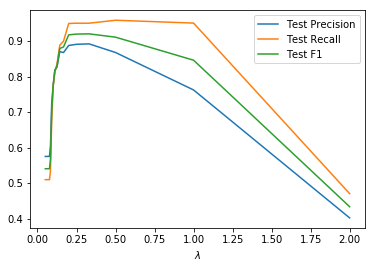

In [32]:
result_df = pd.read_csv(r"C:\phd\rpca\debug\returns_polarity_df.csv")
result_95pct_df = result_df[(result_df['Top %'] == 95) & (result_df['Lambda'] < 3)]

fig, axes = plt.subplots(ncols=1)
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Precision'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Recall'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test F1'])
axes.set_xlabel("$\lambda$")
axes.legend(loc='upper right')
#     axes[0].set_title('Training S&P 500 Adj Close')
#     axes[0].xaxis_date()
#     axes[0].set_ylim(600, 3000)
#     date_format = mdates.DateFormatter('%m/%y')
#     axes[0].xaxis.set_major_formatter(date_format)


In [235]:
result_95pct_df.head()

Lambda  Top %  Bottom %  Training Precision  Training Recall  \
116  0.0500   95.0       5.0            0.723462         0.723462   
117  0.0526   95.0       5.0            0.723462         0.723462   
118  0.0556   95.0       5.0            0.723462         0.723462   
119  0.0588   95.0       5.0            0.723462         0.723462   
120  0.0625   95.0       5.0            0.723462         0.723462   

     Training F1  Validation Precision  Validation Recall  Validation F1  \
116     0.723462              0.757689           0.670307       0.711324   
117     0.723462              0.757689           0.670307       0.711324   
118     0.723462              0.757689           0.670307       0.711324   
119     0.723462              0.757689           0.670307       0.711324   
120     0.723462              0.757689           0.670307       0.711324   

     Test Precision  Test Recall   Test F1  
116        0.575241     0.509844  0.540572  
117        0.575241     0.509844  0.540572  
118        0.575241     0.509844  0.540572  
119        0.575241     0.509844  0.540572  
120        0.575241     0.509844  0.540572

## Plot of Symmetrical KL-Divergence for a $\lambda$

Text(0,0.5,'S&P 500 Adj Close')

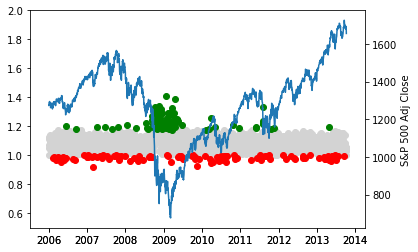

In [93]:
some_lambda_multiplier = 1
topPercentile = 95
bottomPercentile = 5

S_training_df, S_validation_df, S_test_df = get_sparse_dfs("symmetrical-kl-divergence", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies, 
                                                            topPercentile, 
                                                            bottomPercentile)

fig, axes1 = plt.subplots(ncols=1)
    
normal_mask = S_training_df['Anomaly'] == 0
axes1.scatter(S_training_df.index[normal_mask], S_training_df.loc[normal_mask]['PNR'], color="lightgray")
    
positive_mask = S_training_df['Anomaly'] > 0
axes1.scatter(S_training_df.index[positive_mask], S_training_df.loc[positive_mask]['PNR'], color="green")

negative_mask = S_training_df['Anomaly'] < 0
axes1.scatter(S_training_df.index[negative_mask], S_training_df.loc[negative_mask]['PNR'], color="red")

# axes.set_title('Training Constituents Anomalies')
axes1.set_ylim(0.5, 2)
axes1.xaxis_date()
date_format = mdates.DateFormatter('%m/%y')
axes1.xaxis.set_major_formatter(date_format)

axes2 = fig.add_subplot(111, sharex=axes1, frameon=False)
axes2.plot(sp500_training_df.index, sp500_training_df['Adj Close'])
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel("S&P 500 Adj Close")


In [44]:
output_root_dir = get_output_root_dir("training", "symmetrical-kl-divergence")
S = load_sparse_matrix(output_root_dir, some_lambda_multiplier)
# np.savetxt(r"C:\phd\rpca\debug\sparse_symm_kld_df.csv", S_training, delimiter=",")

In [92]:
data = S[-1,:]
x = data[np.where(data > TICKER_ANOMALY_THRESHOLD)]
np.sum(x)

1.0024195382657717

In [49]:
from numpy import linalg as LA

In [84]:
def get_l1_l2_norm(M):
    p_l1_norm = []
    n_l1_norm = []
    
    p_l2_norm = []
    n_l2_norm = []

    for i in np.arange(M.shape[0]):
        data = M[i,:]
        x = data[np.where(data > TICKER_ANOMALY_THRESHOLD)]
        p_l1_norm.append(LA.norm(x, 1))
        p_l2_norm.append(LA.norm(x, 2))

        x = data[np.where(data < (-1*TICKER_ANOMALY_THRESHOLD))]
        n_l1_norm.append(LA.norm(x, 1))
        n_l2_norm.append(LA.norm(x, 2))
        
    return p_l1_norm, n_l1_norm, p_l2_norm, n_l2_norm

In [88]:
np.max(S)

0.3721709038933934

In [85]:
S[abs(S) < TICKER_ANOMALY_THRESHOLD] = 0        
P = (S > 0 ).sum(axis=1)
N = (S < 0 ).sum(axis=1)
Z = (S == 0).sum(axis=1)
M = np.concatenate((P, N, Z), axis=1)
p_l1_norm, n_l1_norm, p_l2_norm, n_l2_norm = get_l1_l2_norm(S)

S_df = pd.DataFrame(M, columns=['P', 'N', 'Z'])
S_df['PNR'] = S_df['P'] / S_df['N']
S_df['P_L1'] = p_l1_norm
S_df['N_L1'] = n_l1_norm
S_df['P_L2'] = p_l2_norm
S_df['N_L2'] = n_l2_norm
S_df.head()

P    N     Z       PNR      P_L1      N_L1      P_L2      N_L2
0  395  375  1184  1.053333  0.047134  0.029306  0.135355  0.073784
1  411  370  1173  1.110811  0.042854  0.040945  0.115488  0.079916
2  384  383  1187  1.002611  0.050230  0.029682  0.109789  0.067131
3  421  374  1159  1.125668  0.052937  0.030205  0.107659  0.064118
4  422  394  1138  1.071066  0.071614  0.040574  0.138399  0.100850

In [86]:
S_df.to_csv(r"C:\phd\rpca\debug\S_df.csv")

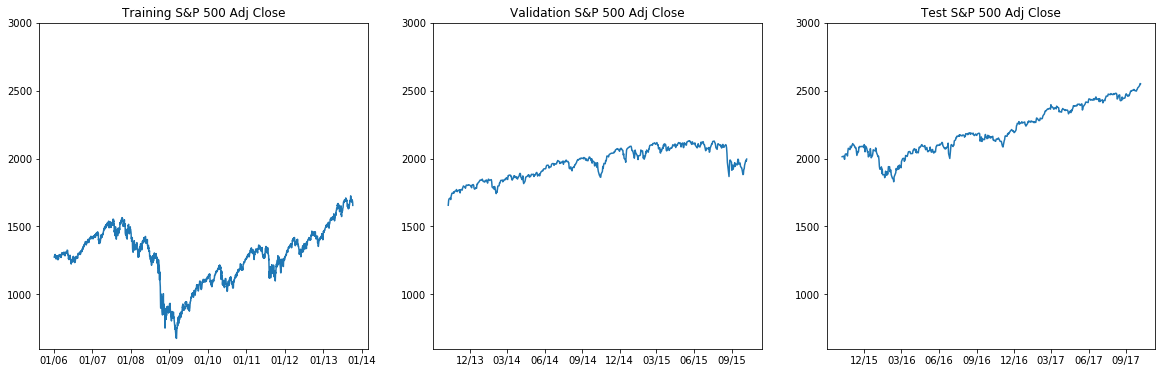

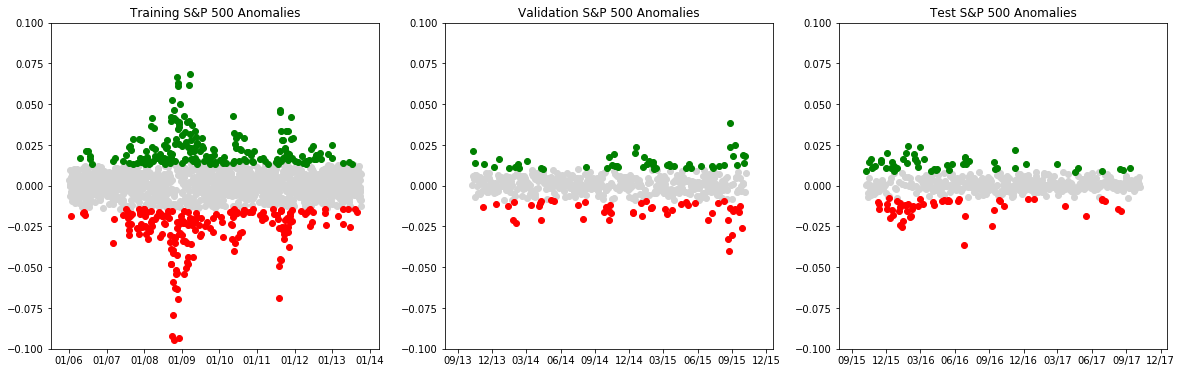

In [84]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
plot_constituents(S_training_df, S_validation_df, S_test_df)

#### $2^{ND}$ ORDER INPUT - SYMMETRICAL KL-DIVERGENCE - DETECTING ANOMALIES

In [96]:
input_types = ["symmetrical-kl-divergence"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

row_idx = 0

result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                   'Training Precision', 'Training Recall', 'Training F1',
                                  'Validation Precision', 'Validation Recall', 'Validation F1',
                                  'Test Precision', 'Test Recall', 'Test F1'])

for percentile in np.arange(1,11):
    topPercentile = 100 - percentile
    bottomPercentile = percentile
    Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile)
    Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile)
    Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile)

    for input_type in input_types:
        print("-----------------------------------------------------------------------------")
        print("%s" % input_type)

        for lambda_multiplier in lam_list:
            print("Processing lambda = {0:.5f}, topPercentile = {1:d}%, bottomPercentile={2:d}%".format(lambda_multiplier, topPercentile, bottomPercentile))
            S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                       lambda_multiplier, 
                                                                       Y_training_anomalies, 
                                                                       Y_validation_anomalies, 
                                                                       Y_test_anomalies,
                                                                       topPercentile, 
                                                                       bottomPercentile)
            
            X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                                S_validation_df.copy(), 
                                                                                S_test_df.copy())        

            training_precision, training_recall, training_f1 = get_metrics(y_train, X_train[:,4])
            val_precision, val_recall, val_f1 = get_metrics(y_val, X_val[:,4])
            test_precision, test_recall, test_f1 = get_metrics(y_test, X_test[:,4])

            result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                                      training_precision, training_recall, training_f1, 
                                      val_precision, val_recall, val_f1, 
                                      test_precision, test_recall, test_f1]
            row_idx = row_idx + 1

# save the returns result data frame
result_df.to_csv(r"C:\phd\rpca\debug\symmetrical_kl_divergence_result_polarity_df.csv")

-----------------------------------------------------------------------------
symmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 99%, bottomPercentile=1%


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Processing lambda = 0.05260, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05560, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05880, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06250, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07140, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07690, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.08330, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.09090, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.10000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.11110, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.12500, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.14290, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.16670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Processing lambda = 3.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 4.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 5.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 6.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 7.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 8.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 9.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 10.00000, topPercentile = 99%, bottomPercentile=1%
-----------------------------------------------------------------------------
symmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05260, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05560, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05880, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.06250, topPercentile = 98%, botto

Processing lambda = 0.33000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.50000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 1.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 2.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 3.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 4.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 5.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 6.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 7.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 8.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 9.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 10.00000, topPercentile = 95%, bottomPercentile=5%
-----------------------------------------------------------------------------
symmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 94%, botto

Processing lambda = 0.14290, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.16670, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.20000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.25000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.33000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.50000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 1.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 2.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 3.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 4.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 5.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 6.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 7.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 8.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 

<hr>

In [99]:
result_df = pd.read_csv(r"C:\phd\rpca\debug\symmetrical_kl_divergence_result_polarity_df.csv")
result_95pct_df = result_df[(result_df['Top %'] == 95) & (result_df['Lambda'] < 3)]

fig, axes = plt.subplots(ncols=1)
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Precision'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Recall'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test F1'])
axes.set_xlabel("$\lambda$")
axes.legend(loc='lower right')

## Plot of <font color="red">Asymmetrical</font> KL-Divergence for a $\lambda$

Text(0,0.5,'S&P 500 Adj Close')

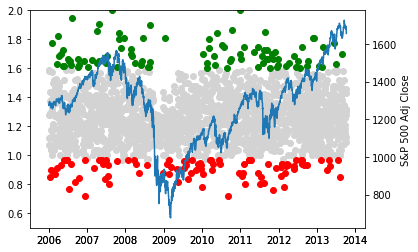

In [104]:
some_lambda_multiplier = 1
topPercentile = 95
bottomPercentile = 5

S_training_df, S_validation_df, S_test_df = get_sparse_dfs("asymmetrical-kl-divergence", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies, 
                                                            topPercentile, 
                                                            bottomPercentile)

fig, axes1 = plt.subplots(ncols=1)
    
normal_mask = S_training_df['Anomaly'] == 0
axes1.scatter(S_training_df.index[normal_mask], S_training_df.loc[normal_mask]['PNR'], color="lightgray")
    
positive_mask = S_training_df['Anomaly'] > 0
axes1.scatter(S_training_df.index[positive_mask], S_training_df.loc[positive_mask]['PNR'], color="green")

negative_mask = S_training_df['Anomaly'] < 0
axes1.scatter(S_training_df.index[negative_mask], S_training_df.loc[negative_mask]['PNR'], color="red")

# axes.set_title('Training Constituents Anomalies')
axes1.set_ylim(0.5, 2)
axes1.xaxis_date()
date_format = mdates.DateFormatter('%m/%y')
axes1.xaxis.set_major_formatter(date_format)

axes2 = fig.add_subplot(111, sharex=axes1, frameon=False)
axes2.plot(sp500_training_df.index, sp500_training_df['Adj Close'])
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel("S&P 500 Adj Close")


In [ ]:
output_root_dir = get_output_root_dir("training", "asymmetrical-kl-divergence")
S = load_sparse_matrix(output_root_dir, some_lambda_multiplier)

In [106]:
S_training_df.to_csv(r"C:\phd\rpca\debug\asymm_kld_S_training_df.csv")

In [104]:
S_training_df.to_csv(r"C:\phd\rpca\debug\S_training_df.csv")

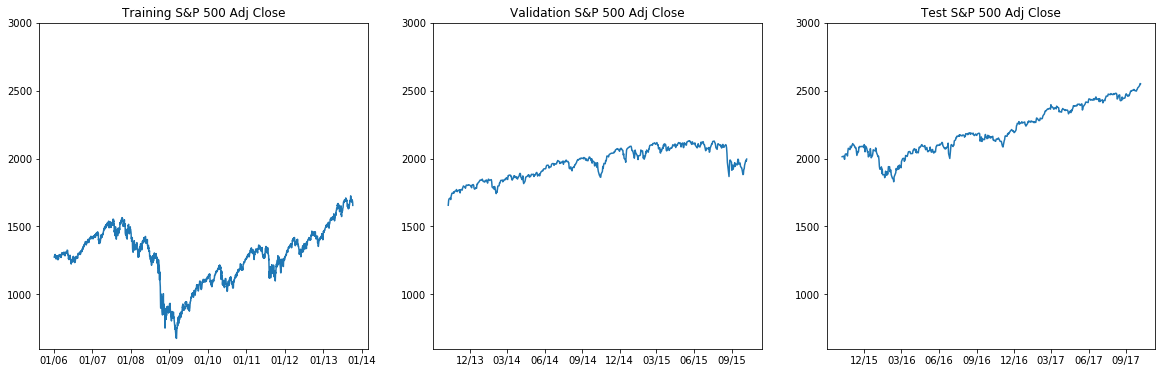

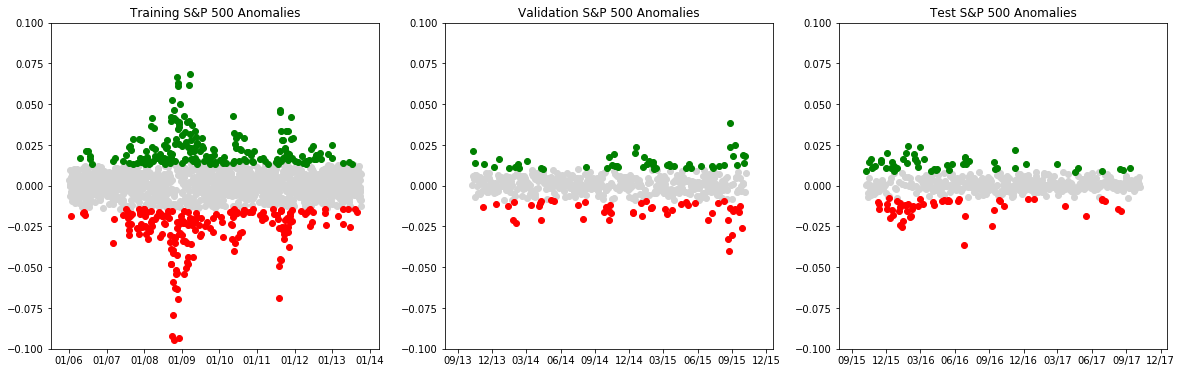

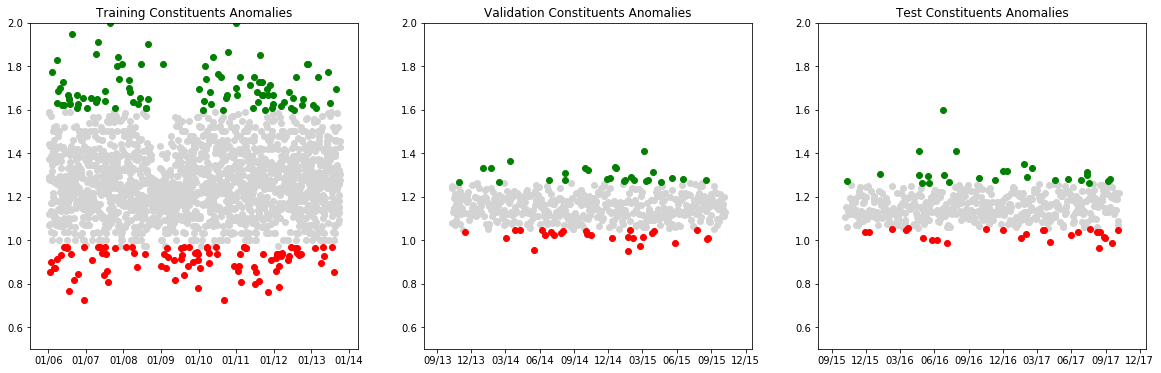

In [88]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
plot_constituents(S_training_df, S_validation_df, S_test_df)

#### $2^{ND}$ ORDER INPUT - <font color="red">ASYMMETRICAL</font> KL-DIVERGENCE - DETECTING ANOMALIES

In [102]:
input_types = ["asymmetrical-kl-divergence"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

row_idx = 0

result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                   'Training Precision', 'Training Recall', 'Training F1',
                                  'Validation Precision', 'Validation Recall', 'Validation F1',
                                  'Test Precision', 'Test Recall', 'Test F1'])

for percentile in np.arange(1,11):
    topPercentile = 100 - percentile
    bottomPercentile = percentile
    Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile)
    Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile)
    Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile)

    for input_type in input_types:
        print("-----------------------------------------------------------------------------")
        print("%s" % input_type)

        for lambda_multiplier in lam_list:
            print("Processing lambda = {0:.5f}, topPercentile = {1:d}%, bottomPercentile={2:d}%".format(lambda_multiplier, topPercentile, bottomPercentile))
            S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                       lambda_multiplier, 
                                                                       Y_training_anomalies, 
                                                                       Y_validation_anomalies, 
                                                                       Y_test_anomalies,
                                                                       topPercentile, 
                                                                       bottomPercentile)
            
            X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                                S_validation_df.copy(), 
                                                                                S_test_df.copy())        

            training_precision, training_recall, training_f1 = get_metrics(y_train, X_train[:,4])
            val_precision, val_recall, val_f1 = get_metrics(y_val, X_val[:,4])
            test_precision, test_recall, test_f1 = get_metrics(y_test, X_test[:,4])

            result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                                      training_precision, training_recall, training_f1, 
                                      val_precision, val_recall, val_f1, 
                                      test_precision, test_recall, test_f1]
            row_idx = row_idx + 1

# save the returns result data frame
result_df.to_csv(r"C:\phd\rpca\debug\asymmetrical_kl_divergence_result_polarity_df.csv")

-----------------------------------------------------------------------------
asymmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 99%, bottomPercentile=1%


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Processing lambda = 0.05260, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05560, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05880, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06250, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07140, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07690, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.08330, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.09090, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.10000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.11110, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.12500, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.14290, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.16670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


Processing lambda = 3.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 4.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 5.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 6.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 7.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 8.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 9.00000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 10.00000, topPercentile = 99%, bottomPercentile=1%
-----------------------------------------------------------------------------
asymmetrical-kl-divergence
Processing lambda = 0.05000, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05260, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05560, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.05880, topPercentile = 98%, bottomPercentile=2%
Processing lambda = 0.06250, topPercentile = 98%, bott

Processing lambda = 0.25000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.33000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.50000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 1.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 2.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 3.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 4.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 5.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 6.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 7.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 8.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 9.00000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 10.00000, topPercentile = 95%, bottomPercentile=5%
-----------------------------------------------------------------------------
asymmetrica

Processing lambda = 0.11110, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.12500, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.14290, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.16670, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.20000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.25000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.33000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.50000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 1.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 2.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 3.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 4.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 5.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 6.00000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 

<hr>

In [107]:
result_df = pd.read_csv(r"C:\phd\rpca\debug\asymmetrical_kl_divergence_result_polarity_df.csv")
result_95pct_df = result_df[(result_df['Top %'] == 95) & (result_df['Lambda'] < 3)]

fig, axes = plt.subplots(ncols=1)
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Precision'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Recall'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test F1'])
axes.set_xlabel("$\lambda$")
axes.legend(loc='lower right')

## Plot of <font color="red">Euclidean Distance</font> for a $\lambda$

Text(0,0.5,'S&P 500 Adj Close')

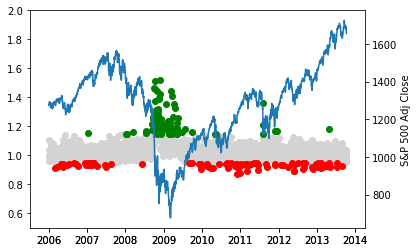

In [108]:
some_lambda_multiplier = 1
topPercentile = 95
bottomPercentile = 5
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("euclidean-distances", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies, 
                                                            topPercentile, 
                                                            bottomPercentile)
fig, axes1 = plt.subplots(ncols=1)
    
normal_mask = S_training_df['Anomaly'] == 0
axes1.scatter(S_training_df.index[normal_mask], S_training_df.loc[normal_mask]['PNR'], color="lightgray")
    
positive_mask = S_training_df['Anomaly'] > 0
axes1.scatter(S_training_df.index[positive_mask], S_training_df.loc[positive_mask]['PNR'], color="green")

negative_mask = S_training_df['Anomaly'] < 0
axes1.scatter(S_training_df.index[negative_mask], S_training_df.loc[negative_mask]['PNR'], color="red")

axes1.set_ylim(0.5, 2)
axes1.xaxis_date()
date_format = mdates.DateFormatter('%m/%y')
axes1.xaxis.set_major_formatter(date_format)

axes2 = fig.add_subplot(111, sharex=axes1, frameon=False)
axes2.plot(sp500_training_df.index, sp500_training_df['Adj Close'])
axes2.yaxis.tick_right()
axes2.yaxis.set_label_position("right")
axes2.set_ylabel("S&P 500 Adj Close")


In [109]:
# S_training_df.to_csv(r"C:\phd\rpca\debug\S_training_df.csv")
S_training_df.to_csv(r"C:\phd\rpca\debug\euclidean_dist_S_training_df.csv")

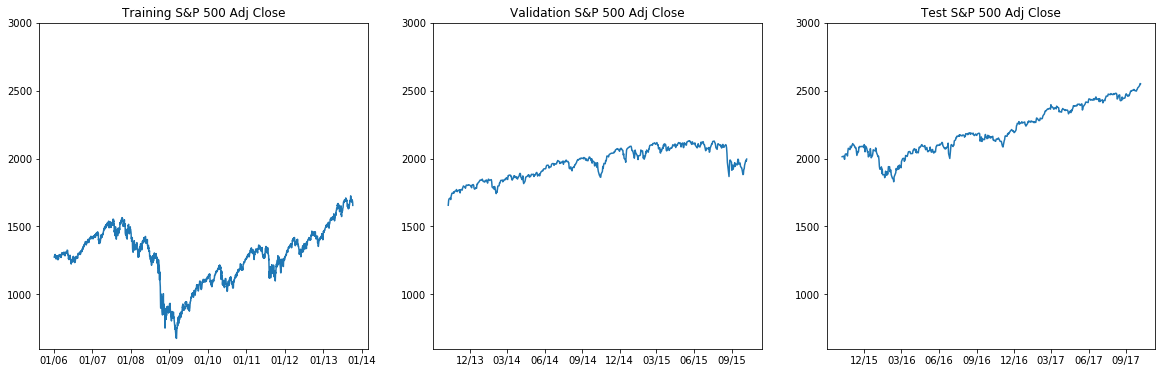

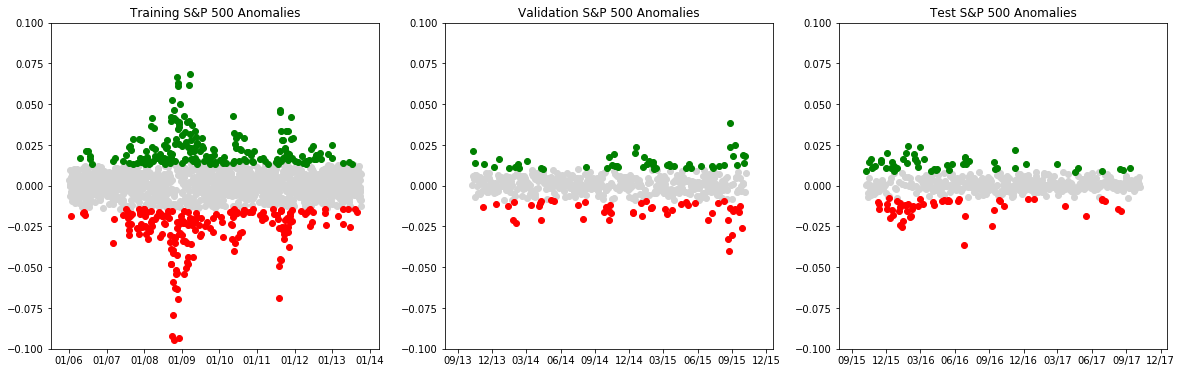

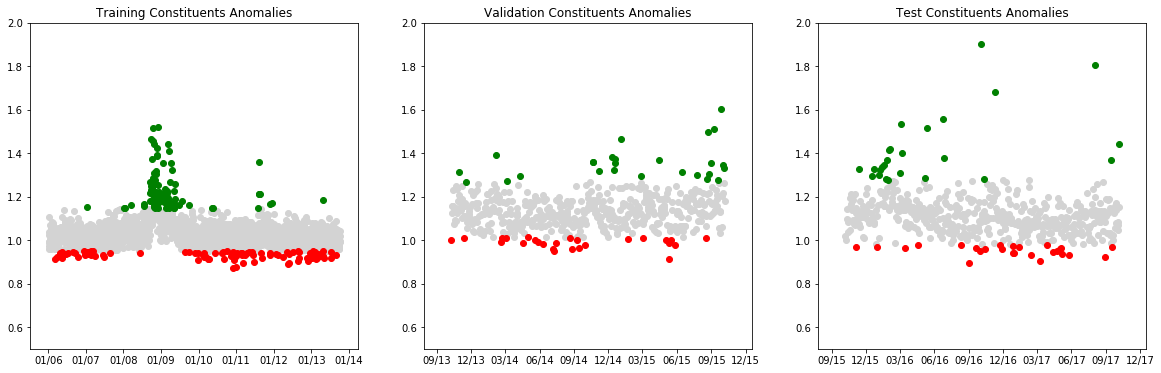

In [91]:
plot_sp500(sp500_training_df, sp500_validation_df, sp500_test_df)
plot_sp500_anomalies(Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies)
plot_constituents(S_training_df, S_validation_df, S_test_df)

#### $2^{ND}$ ORDER INPUT - <font color="red">EUCLIDEAN DISTANCES</font> - DETECTING ANOMALIES

In [110]:
input_types = ["euclidean-distances"]
dataset_types = ["training", "validation", "test"]
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]

row_idx = 0

result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                   'Training Precision', 'Training Recall', 'Training F1',
                                  'Validation Precision', 'Validation Recall', 'Validation F1',
                                  'Test Precision', 'Test Recall', 'Test F1'])

for percentile in np.arange(1,11):
    topPercentile = 100 - percentile
    bottomPercentile = percentile
    Y_training_anomalies = get_sp500_anomalies(sp500_training_df.copy(), topPercentile, bottomPercentile)
    Y_validation_anomalies = get_sp500_anomalies(sp500_validation_df.copy(), topPercentile, bottomPercentile)
    Y_test_anomalies = get_sp500_anomalies(sp500_test_df.copy(), topPercentile, bottomPercentile)

    for input_type in input_types:
        print("-----------------------------------------------------------------------------")
        print("%s" % input_type)

        for lambda_multiplier in lam_list:
            print("Processing lambda = {0:.5f}, topPercentile = {1:d}%, bottomPercentile={2:d}%".format(lambda_multiplier, topPercentile, bottomPercentile))
            S_training_df, S_validation_df, S_test_df = get_sparse_dfs(input_type, 
                                                                       lambda_multiplier, 
                                                                       Y_training_anomalies, 
                                                                       Y_validation_anomalies, 
                                                                       Y_test_anomalies,
                                                                       topPercentile, 
                                                                       bottomPercentile)
            
            X_train, y_train, X_val, y_val, X_test, y_test = get_train_val_test(S_training_df.copy(), 
                                                                                S_validation_df.copy(), 
                                                                                S_test_df.copy())        

            training_precision, training_recall, training_f1 = get_metrics(y_train, X_train[:,4])
            val_precision, val_recall, val_f1 = get_metrics(y_val, X_val[:,4])
            test_precision, test_recall, test_f1 = get_metrics(y_test, X_test[:,4])

            result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                                      training_precision, training_recall, training_f1, 
                                      val_precision, val_recall, val_f1, 
                                      test_precision, test_recall, test_f1]
            row_idx = row_idx + 1

# save the returns result data frame
result_df.to_csv(r"C:\phd\rpca\debug\euclidean-distances_result_polarity_df.csv")    

-----------------------------------------------------------------------------
euclidean-distances
Processing lambda = 0.05000, topPercentile = 99%, bottomPercentile=1%


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Processing lambda = 0.05260, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05560, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.05880, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06250, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.06670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07140, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.07690, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.08330, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.09090, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.10000, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.11110, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.12500, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.14290, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 0.16670, topPercentile = 99%, bottomPercentile=1%
Processing lambda = 

Processing lambda = 9.00000, topPercentile = 96%, bottomPercentile=4%
Processing lambda = 10.00000, topPercentile = 96%, bottomPercentile=4%
-----------------------------------------------------------------------------
euclidean-distances
Processing lambda = 0.05000, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.05260, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.05560, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.05880, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.06250, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.06670, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.07140, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.07690, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.08330, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.09090, topPercentile = 95%, bottomPercentile=5%
Processing lambda = 0.10000, topPercentile = 95%, bottomPerce

Processing lambda = 5.00000, topPercentile = 92%, bottomPercentile=8%
Processing lambda = 6.00000, topPercentile = 92%, bottomPercentile=8%
Processing lambda = 7.00000, topPercentile = 92%, bottomPercentile=8%
Processing lambda = 8.00000, topPercentile = 92%, bottomPercentile=8%
Processing lambda = 9.00000, topPercentile = 92%, bottomPercentile=8%
Processing lambda = 10.00000, topPercentile = 92%, bottomPercentile=8%
-----------------------------------------------------------------------------
euclidean-distances
Processing lambda = 0.05000, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.05260, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.05560, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.05880, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.06250, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.06670, topPercentile = 91%, bottomPercentile=9%
Processing lambda = 0.07140, topPercentile = 91%, bottomPerce

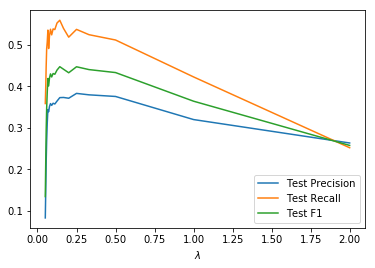

In [111]:
result_df = pd.read_csv(r"C:\phd\rpca\debug\euclidean-distances_result_polarity_df.csv")
result_95pct_df = result_df[(result_df['Top %'] == 95) & (result_df['Lambda'] < 3)]

fig, axes = plt.subplots(ncols=1)
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Precision'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test Recall'])
axes.plot(result_95pct_df['Lambda'], result_95pct_df['Test F1'])
axes.set_xlabel("$\lambda$")
axes.legend(loc='lower right')

# TODO

Take the best case from:

<ol>
    <li>Returns Test Result and for that combination - generate the Anomaly Detection vs. S&amp;P 500
    <li>Same thing for Symmetrical KL Divergence
    <li>Same thing for Asymmetrical KL Divergence
    <li>Same thing for Euclidean Distances
    <li>Try what do we get by using the older version of H matrix / both symmetrical and asymmetrical
</ol>

# Zoom Ins...how did all algo do

#### Returns -  Detailed Analysis of S&P 500 Anomalies vs. Detected Anomalies

In [112]:
returns_output_df = pd.DataFrame()
best_lambda_multiplier = 0.33
topPercentile = 95
bottomPercentile = 5
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("returns", 
                                                            best_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies, 
                                                            topPercentile, 
                                                            bottomPercentile)

returns_output_df['RET_P'] = S_test_df['P']
returns_output_df['RET_N'] = S_test_df['N']
returns_output_df['RET_Z'] = S_test_df['Z']
returns_output_df['RET_PNR'] = S_test_df['PNR']
returns_output_df['RET_Anomaly'] = S_test_df['Anomaly']

#### Euclidean Distances -  Detailed Analysis of S&P 500 Anomalies vs. Detected Anomalies

In [113]:
best_lambda_multiplier = 0.25
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("euclidean-distances", 
                                                            best_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies, 
                                                            topPercentile, 
                                                            bottomPercentile)

returns_output_df['DIST_P'] = S_test_df['P']
returns_output_df['DIST_N'] = S_test_df['N']
returns_output_df['DIST_Z'] = S_test_df['Z']
returns_output_df['DIST_PNR'] = S_test_df['PNR']
returns_output_df['DIST_Anomaly'] = S_test_df['Anomaly']

#### Symmetrical KL Divergence -  Detailed Analysis of S&P 500 Anomalies vs. Detected Anomalies

In [114]:
best_lambda_multiplier = 0.0556
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("symmetrical-kl-divergence", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies, 
                                                            topPercentile, 
                                                            bottomPercentile)

returns_output_df['SYMM_KL_P'] = S_test_df['P']
returns_output_df['SYMM_KL_N'] = S_test_df['N']
returns_output_df['SYMM_KL_Z'] = S_test_df['Z']
returns_output_df['SYMM_KL_PNR'] = S_test_df['PNR']
returns_output_df['SYMM_KL_Anomaly'] = S_test_df['Anomaly']

#### Asymmetrical KL Divergence -  Detailed Analysis of S&P 500 Anomalies vs. Detected Anomalies

In [115]:
some_lambda_multiplier = 0.0833
S_training_df, S_validation_df, S_test_df = get_sparse_dfs("asymmetrical-kl-divergence", 
                                                            some_lambda_multiplier, 
                                                            Y_training_anomalies, 
                                                            Y_validation_anomalies, 
                                                            Y_test_anomalies, 
                                                            topPercentile, 
                                                            bottomPercentile)

returns_output_df['ASYMM_KL_P'] = S_test_df['P']
returns_output_df['ASYMM_KL_N'] = S_test_df['N']
returns_output_df['ASYMM_KL_Z'] = S_test_df['Z']
returns_output_df['ASYMM_KL_PNR'] = S_test_df['PNR']
returns_output_df['ASYMM_KL_Anomaly'] = S_test_df['Anomaly']

In [116]:
returns_output_df['SP500_RETURN'] = Y_test_anomalies['Return']
returns_output_df['SP500_Anomaly'] = Y_test_anomalies['Anomaly']

In [117]:
returns_output_df.head()

RET_P  RET_N  RET_Z   RET_PNR  RET_Anomaly  DIST_P  DIST_N  \
Date                                                                     
2015-10-08    331    201     17  1.646766            1     286     208   
2015-10-09    265    267     17  0.992509            0     276     219   
2015-10-12    281    248     20  1.133065            0     280     211   
2015-10-13    225    310     14  0.725806            0     280     218   
2015-10-14    232    302     15  0.768212            0     294     203   

            DIST_Z  DIST_PNR  DIST_Anomaly      ...        SYMM_KL_Z  \
Date                                            ...                    
2015-10-08      10  1.375000             0      ...              218   
2015-10-09       9  1.260274             0      ...              225   
2015-10-12      13  1.327014             0      ...              230   
2015-10-13       6  1.284404             0      ...              218   
2015-10-14       7  1.448276             1      ...              222   

            SYMM_KL_PNR  SYMM_KL_Anomaly  ASYMM_KL_P  ASYMM_KL_N  ASYMM_KL_Z  \
Date                                                                           
2015-10-08     1.150376                0         379         123           2   
2015-10-09     1.051471                0         394         106           4   
2015-10-12     1.091603                0         380         123           1   
2015-10-13     1.150376                0         389         114           1   
2015-10-14     1.152672                0         382         120           2   

            ASYMM_KL_PNR  ASYMM_KL_Anomaly  SP500_RETURN  SP500_Anomaly  
Date                                                                     
2015-10-08      3.081301                 0      0.008780              1  
2015-10-09      3.716981                 0      0.000725              0  
2015-10-12      3.089431                 0      0.001275              0  
2015-10-13      3.412281                 0     -0.006849              0  
2015-10-14      3.183333                 0     -0.004727              0  

[5 rows x 22 columns]

In [119]:
returns_output_df.to_csv(r"C:\phd\rpca\debug\returns_output_df.csv")

## Intraday

In [172]:
from datetime import datetime

In [199]:
intd_df = pd.read_csv(r"C:\phd\rpca\input\intraday\2011JulyAug.csv")
sp500_const_df = pd.read_csv(r"C:\phd\rpca\input\prices\sp500_constituents_eod_prices.csv")

In [200]:
lst1 = list(intd_df.columns[1:])
lst2 = list(sp500_const_df.columns[1:])
tickers = list(set(lst1) & set(lst2))
tickers = sorted(tickers)
tickers.insert(0, "DateTime")

In [201]:
print(tickers)

['DateTime', 'A', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AET', 'AFL', 'AGN', 'AIG', 'AIV', 'AIZ', 'AKAM', 'AKS', 'ALL', 'ALXN', 'AMAT', 'AMD', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN', 'ANF', 'AON', 'APA', 'APC', 'APD', 'APH', 'APOL', 'ASH', 'ATI', 'ATVI', 'AVB', 'AVGO', 'AVP', 'AVY', 'AWK', 'AXP', 'BA', 'BAC', 'BAX', 'BBBY', 'BBT', 'BBY', 'BC', 'BCR', 'BDX', 'BEN', 'BHI', 'BIG', 'BIIB', 'BK', 'BLK', 'BLL', 'BMS', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH', 'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CDE', 'CELG', 'CERN', 'CF', 'CHK', 'CHRW', 'CI', 'CIEN', 'CINF', 'CL', 'CLF', 'CLX', 'CMA', 'CMG', 'CMI', 'CMS', 'CNP', 'CNX', 'COF', 'COG', 'COL', 'COP', 'COST', 'CPB', 'CRM', 'CSC', 'CSCO', 'CSX', 'CTAS', 'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DDR', 'DDS', 'DE', 'DF', 'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DLTR', 'DNR', 'DO', 'DOV', 'DOW', 'DPS', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'EBAY', 'ECL', 'ED', 'EF

In [202]:
sp500_intd_df = intd_df[tickers]

In [203]:
sp500_intd_df['date'] = pd.to_datetime(sp500_intd_df['DateTime'])
sp500_intd_df.index = sp500_intd_df['date']
del sp500_intd_df['date']
del sp500_intd_df['DateTime']
sp500_intd_df.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


A    AAP    AAPL    ABC    ABT    ACN   ADBE  \
date                                                                      
2011-07-05 09:30:00  51.9501  58.86  342.83  42.15  53.11  60.66  31.32   
2011-07-05 09:31:00  51.7600  58.59  343.46  41.99  53.10  60.63  31.35   
2011-07-05 09:32:00  51.7700  58.50  344.35  41.92  53.11  60.64  31.37   
2011-07-05 09:33:00  51.6900  58.48  343.95  41.97  53.16  60.68  31.36   
2011-07-05 09:34:00  51.7200  58.72  344.87  42.00  53.17  60.68  31.34   

                         ADI     ADM    ADP   ...           X      XEC    XEL  \
date                                          ...                               
2011-07-05 09:30:00  39.9298  30.885  53.87   ...     46.6924  90.7066  24.66   
2011-07-05 09:31:00  39.9000  30.720  53.81   ...     46.6260  90.4400  24.66   
2011-07-05 09:32:00  39.8900  30.680  53.68   ...     46.6000  90.4300  24.65   
2011-07-05 09:33:00  39.9500  30.650  53.71   ...     46.5232  90.5300  24.64   
2011-07-05 09:34:00  39.9800  30.580  53.65   ...     46.5400  90.7300  24.61   

                        XL   XLNX     XOM     XRAY      XRX     YUM     ZION  
date                                                                          
2011-07-05 09:30:00  22.21  37.05  81.300  38.5191  10.6975  56.820  24.3200  
2011-07-05 09:31:00  22.16  37.04  81.620  38.5500  10.7000  56.751  24.2985  
2011-07-05 09:32:00  22.14  37.03  81.805  38.5500  10.6900  56.830  24.2400  
2011-07-05 09:33:00  22.11  37.14  81.900  38.5600  10.6699  56.870  24.1100  
2011-07-05 09:34:00  29.93  37.14  82.000  38.5200  10.6400  56.770  24.1400  

[5 rows x 462 columns]

In [207]:
df = pd.read_csv(r"C:\phd\rpca\input\intraday\2009JanFebMar-SP500-Constituents.csv")
df.index = df['date']
del df['date']
df.head()

A    AAP     AAPL    ABC    ABT    ACN    ADBE  \
date                                                                      
2009-01-02 09:30:00  15.63  33.53  85.7600    NaN  53.14  32.54  21.130   
2009-01-02 09:31:00  15.55  33.78  85.4700    NaN  53.24  32.77  21.150   
2009-01-02 09:32:00  15.56  33.69  85.6717    NaN  53.31  32.77  21.136   
2009-01-02 09:33:00  15.56  33.53  86.2900  35.83  53.30  32.74  21.080   
2009-01-02 09:34:00  15.58  33.46  86.5400  35.76  53.23  32.79  21.140   

                         ADI    ADM    ADP  ...          X    XEC    XEL  \
date                                        ...                            
2009-01-02 09:30:00  18.9900  28.78  39.05  ...    37.8500  26.75  18.71   
2009-01-02 09:31:00  18.9499  28.69  39.25  ...    37.7950  27.24  18.54   
2009-01-02 09:32:00  18.8800  28.71  39.31  ...    38.0899  27.28  18.57   
2009-01-02 09:33:00  18.8100  28.65  39.14  ...    38.0600  27.28  18.54   
2009-01-02 09:34:00  18.8500  37.77  39.20  ...    38.4600  27.28  67.21   

                         XL   XLNX    XOM    XRAY   XRX    YUM   ZION  
date                                                                   
2009-01-02 09:30:00  3.7800  17.70  79.80  28.252  7.95  31.88  25.20  
2009-01-02 09:31:00  3.7900  17.74  79.61  28.280  8.03  31.71  25.20  
2009-01-02 09:32:00  3.7899  17.75  79.65  28.308  8.04  31.72  25.23  
2009-01-02 09:33:00  3.7400  17.71  79.53  28.270  7.98  31.70  25.16  
2009-01-02 09:34:00  3.7282  17.71  79.59  28.295  7.97  31.69  25.20  

[5 rows x 467 columns]

In [219]:
# np.unique() # .
date_time = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df.index]

In [221]:
date = [datetime.strftime(dt, '%Y-%m-%d') for dt in date_time]
# np.unique(date_time.dt.strftime('%d-%m-%y'))

In [240]:
type(date_time[0])

datetime.datetime

In [222]:
np.unique(date)

array(['2009-01-02', '2009-01-05', '2009-01-06', '2009-01-07',
       '2009-01-08', '2009-01-09', '2009-01-12', '2009-01-13',
       '2009-01-14', '2009-01-15', '2009-01-16', '2009-01-20',
       '2009-01-21', '2009-01-22', '2009-01-23', '2009-01-26',
       '2009-01-27', '2009-01-28', '2009-01-29', '2009-01-30',
       '2009-02-02', '2009-02-03', '2009-02-04', '2009-02-05',
       '2009-02-06', '2009-02-09', '2009-02-10', '2009-02-11',
       '2009-02-12', '2009-02-13', '2009-02-17', '2009-02-18',
       '2009-02-19', '2009-02-20', '2009-02-23', '2009-02-24',
       '2009-02-25', '2009-02-26', '2009-02-27', '2009-03-02',
       '2009-03-03', '2009-03-04', '2009-03-05', '2009-03-06',
       '2009-03-09', '2009-03-10', '2009-03-11', '2009-03-12',
       '2009-03-13', '2009-03-16', '2009-03-17', '2009-03-18',
       '2009-03-19', '2009-03-20', '2009-03-23', '2009-03-24',
       '2009-03-25', '2009-03-26', '2009-03-27', '2009-03-30',
       '2009-03-31'], dtype='<U10')

In [232]:
df.index = pd.to_datetime(df.index)

In [234]:
df.index[0].dayofweek

4

In [235]:
a = df[df.index == '2009-01-02']

In [236]:
a

Empty DataFrame
Columns: [A, AAP, AAPL, ABC, ABT, ACN, ADBE, ADI, ADM, ADP, ADS, ADSK, AEE, AEP, AES, AET, AFL, AGN, AIG, AIV, AIZ, AJG, AKAM, AKS, ALL, ALXN, AMAT, AMD, AME, AMG, AMGN, AMP, AMT, AMZN, AN, ANF, APA, APC, APD, APH, APOL, ASH, ATI, ATVI, AVB, AVP, AVY, AXP, AZO, BA, BAC, BAX, BBBY, BBT, BBY, BCR, BDX, BEN, BHI, BIG, BIIB, BK, BLL, BMS, BMY, BSX, BWA, BXP, C, CA, CAG, CAH, CAT, CB, CBG, CBS, CCI, CCL, CDE, CELG, CERN, CF, CHK, CHRW, CI, CIEN, CINF, CL, CLF, CLX, CMA, CME, CMI, CMS, CNP, CNX, COF, COG, COL, COP, ...]
Index: []

[0 rows x 467 columns]

In [241]:
import os

In [244]:
files_list = os.listdir(r"C:\phd\rpca\input\intraday\prices\2009")

In [245]:
files_list[0]

'2009-01-02.csv'

In [248]:
root_dir = r"C:\phd\rpca\input\intraday\prices\2009"
for filename in files_list:
    full_path = root_dir + "\\" + filename
    df = pd.read_csv(full_path)
    df.set_index(df['date'], inplace=True)
    df.drop('date', axis=1, inplace=True)
    df_ret = np.log(df / df.shift())
    df = df_ret.iloc[1:]


In [249]:
df.head()

A       AAP      AAPL       ABC       ABT  \
date                                                                    
2009-03-31 09:31:00       NaN  0.001197  0.000852  0.001858 -0.002074   
2009-03-31 09:32:00  0.001285 -0.005038  0.000473  0.000928  0.000415   
2009-03-31 09:33:00 -0.001927 -0.001203 -0.000096  0.002161  0.001452   
2009-03-31 09:34:00 -0.003221 -0.002652 -0.001135  0.001233  0.000414   
2009-03-31 09:35:00  0.003221 -0.004840 -0.002181  0.000616  0.000621   

                          ACN      ADBE       ADI       ADM       ADP  \
date                                                                    
2009-03-31 09:31:00  0.009479  0.000000 -0.002057 -0.003264  0.011361   
2009-03-31 09:32:00 -0.002543  0.001432  0.008201  0.285318 -0.000565   
2009-03-31 09:33:00  0.000727 -0.000955  0.000000 -0.286045 -0.000283   
2009-03-31 09:34:00 -0.000727  0.000477 -0.000511  0.000363 -0.000848   
2009-03-31 09:35:00 -0.000728  0.000000 -0.000511  0.284039 -0.003684   

                       ...            X       XEC       XEL        XL  \
date                   ...                                              
2009-03-31 09:31:00    ...    -0.005742 -0.005816 -0.002733 -0.003752   
2009-03-31 09:32:00    ...    -0.006663  0.002645  0.001641  0.009355   
2009-03-31 09:33:00    ...    -0.004170  0.006858  0.001638  0.005571   
2009-03-31 09:34:00    ...     0.002782 -0.006858 -0.001092 -0.013048   
2009-03-31 09:35:00    ...     0.000000  0.005806  0.000000  0.001874   

                         XLNX       XOM      XRAY       XRX       YUM  \
date                                                                    
2009-03-31 09:31:00  0.001544 -0.001308 -0.001517  0.000000 -0.013307   
2009-03-31 09:32:00  0.005648 -0.000145  0.002654 -0.002144  0.005056   
2009-03-31 09:33:00  0.000506  0.000291  0.000076  0.002144  0.001440   
2009-03-31 09:34:00  0.000511 -0.001164  0.002571 -0.004292 -0.002161   
2009-03-31 09:35:00 -0.003481  0.000000  0.000000  0.002148 -0.002527   

                         ZION  
date                           
2009-03-31 09:31:00  0.000000  
2009-03-31 09:32:00  0.003099  
2009-03-31 09:33:00  0.001059  
2009-03-31 09:34:00 -0.006244  
2009-03-31 09:35:00 -0.002079  

[5 rows x 467 columns]

## Random Forest Classifier

### Returns

In [255]:
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]


prediction_result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                              'Test Accuracy', 'Test Precision', 
                                              'Test Recall', 'Test F1', 'Test F2', '# of Unique Values'])

row_idx = 0
percentile = 5
topPercentile = 100 - percentile
bottomPercentile = 2*percentile

# let us ignore polarity for now, so pass False
Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies = get_anomalies_dfs(sp500_training_df.copy(), 
                                                                                   sp500_validation_df.copy(), 
                                                                                   sp500_test_df.copy(), 
                                                                                   topPercentile, 
                                                                                   bottomPercentile, 
                                                                                   polarity=True)
y_train = Y_training_anomalies.iloc[0:,]['Anomaly']
y_val = Y_validation_anomalies.iloc[0:,]['Anomaly']
y_test = Y_test_anomalies.iloc[0:,]['Anomaly']

print("Processing percentile: {0:d}".format(percentile))

for lambda_multiplier in lam_list:
    print("\tLambda Multiplier: {0:.4f}".format(lambda_multiplier))
    output_root_dir = get_output_root_dir("training", "returns")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_train = S[:,]

    output_root_dir = get_output_root_dir("validation", "returns")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_val = S[:,]

    output_root_dir = get_output_root_dir("test", "returns")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_test = S[:,]

    # loop invaraint
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    pred_y = clf.predict(X_train)

    pred_y_test = clf.predict(X_test)
    print("\t\t Unique values in TEST: {0}".format(np.unique( pred_y_test )))
    test_accuracy = accuracy_score(y_test, pred_y_test)
    print("\t\t TEST Accuracy: {0}".format(test_accuracy))

    test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=1.0, average="macro")
    _, _, test_f2_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=2.0, average="macro")
    print("\t\t TEST Precision: {0}".format(test_precision))
    print("\t\t TEST Recall: {0}".format(test_recall))
    print("\t\t TEST f1 score: {0}".format(test_f1_score))
    print("\t\t TEST f2 score: {0}".format(test_f2_score))

    prediction_result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                              test_accuracy, test_precision, test_recall, test_f1_score, 
                                         test_f2_score, len(np.unique( pred_y_test ))]

    row_idx = row_idx + 1        

Processing percentile: 5
	Lambda Multiplier: 0.0500
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9781746031746031
		 TEST Precision: 0.6390027322404371
		 TEST Recall: 0.5826374391092554
		 TEST f1 score: 0.6073193151786741
		 TEST f2 score: 0.5918087909040488
	Lambda Multiplier: 0.0526


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9742063492063492
		 TEST Precision: 0.9911924119241192
		 TEST Recall: 0.5833333333333334
		 TEST f1 score: 0.6765408310539702
		 TEST f2 score: 0.612364057131499
	Lambda Multiplier: 0.0556
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9722222222222222
		 TEST Precision: 0.9442009932807478
		 TEST Recall: 0.5986082115518442
		 TEST f1 score: 0.6749176254523848
		 TEST f2 score: 0.6226923673732184
	Lambda Multiplier: 0.0588
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9722222222222222
		 TEST Precision: 0.9633966960850872
		 TEST Recall: 0.5826374391092554
		 TEST f1 score: 0.6688001145475372
		 TEST f2 score: 0.6096195304527886
	Lambda Multiplier: 0.0625
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9761904761904762
		 TEST Precision: 0.9668606785171203
		 TEST Recall: 0.6659707724425887
		 TEST f1 score: 0.7621015348288077
		 TEST f2 score: 0.697823246210343
	Lambda Multiplier: 0.0667
		 Unique 

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9603174603174603
		 TEST Precision: 0.7477650063856961
		 TEST Recall: 0.5145789839944329
		 TEST f1 score: 0.5826322582388993
		 TEST f2 score: 0.5361643213728792
	Lambda Multiplier: 0.0769
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9682539682539683
		 TEST Precision: 0.6058802026215467
		 TEST Recall: 0.5152748782185108
		 TEST f1 score: 0.550057273768614
		 TEST f2 score: 0.5274192803844224
	Lambda Multiplier: 0.0833


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9563492063492064
		 TEST Precision: 0.5440144829146866
		 TEST Recall: 0.46318719554627696
		 TEST f1 score: 0.49243986254295535
		 TEST f2 score: 0.47313692551314707
	Lambda Multiplier: 0.0909
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9801587301587301
		 TEST Precision: 0.6285024154589373
		 TEST Recall: 0.6312456506610995
		 TEST f1 score: 0.62986832986833
		 TEST f2 score: 0.630693344449076
	Lambda Multiplier: 0.1000
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9781746031746031
		 TEST Precision: 0.7791666666666667
		 TEST Recall: 0.7465205288796103
		 TEST f1 score: 0.7609913876337235
		 TEST f2 score: 0.7519384158783157
	Lambda Multiplier: 0.1111
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9583333333333334
		 TEST Precision: 0.6403694944717321
		 TEST Recall: 0.625678496868476
		 TEST f1 score: 0.6264064056766543
		 TEST f2 score: 0.6248155212852731
	Lambda Multiplier: 0.1250
		 Unique

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9642857142857143
		 TEST Precision: 0.5795602903545877
		 TEST Recall: 0.4979123173277662
		 TEST f1 score: 0.5291679683432261
		 TEST f2 score: 0.5088057085591159
	Lambda Multiplier: 0.2500


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9623015873015873
		 TEST Precision: 0.8982508006898251
		 TEST Recall: 0.5312456506610995
		 TEST f1 score: 0.6099649697869026
		 TEST f2 score: 0.5553425902263113
	Lambda Multiplier: 0.3300
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.48712737127371275
		 TEST Recall: 0.4291579679888657
		 TEST f1 score: 0.44975111568829385
		 TEST f2 score: 0.43607660455486535
	Lambda Multiplier: 0.5000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9444444444444444
		 TEST Precision: 0.38396793587174344
		 TEST Recall: 0.3472164231036882
		 TEST f1 score: 0.3504567143830947
		 TEST f2 score: 0.3474201274712783
	Lambda Multiplier: 1.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.42847638057218895
		 TEST Recall: 0.3486082115518441
		 TEST f1 score: 0.3534753031647442
		 TEST f2 score: 0.34900047023011366
	Lambda Multiplier: 2.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9424603174603174
		 TEST Precision: 0.31666666666666665
		 TEST Recall: 0.33054975643702156
		 TEST f1 score: 0.32345931222335716
		 TEST f2 score: 0.3276766004415011
	Lambda Multiplier: 3.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9464285714285714
		 TEST Precision: 0.31673306772908366
		 TEST Recall: 0.33194154488517746
		 TEST f1 score: 0.32415902140672787
		 TEST f2 score: 0.3287841191066998
	Lambda Multiplier: 4.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9384920634920635
		 TEST Precision: 0.31659973226238286
		 TEST Recall: 0.3291579679888657
		 TEST f1 score: 0.32275673831456847
		 TEST f2 score: 0.32656724661695663
	Lambda Multiplier: 5.0000
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.3167660702451955
		 TEST Recall: 0.3326374391092554
		 TEST f1 score: 0.32450780719619826
		 TEST f2 score: 0.3293371916770015
	Lambda Multiplier: 6.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.3167660702451955
		 TEST Recall: 0.3326374391092554
		 TEST f1 score: 0.32450780719619826
		 TEST f2 score: 0.3293371916770015
	Lambda Multiplier: 7.0000
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9464285714285714
		 TEST Precision: 0.31673306772908366
		 TEST Recall: 0.33194154488517746
		 TEST f1 score: 0.32415902140672787
		 TEST f2 score: 0.3287841191066998
	Lambda Multiplier: 8.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.42847638057218895
		 TEST Recall: 0.3486082115518441
		 TEST f1 score: 0.3534753031647442
		 TEST f2 score: 0.34900047023011366
	Lambda Multiplier: 9.0000
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.48406374501992033
		 TEST Recall: 0.3493041057759221
		 TEST f1 score: 0.35514163037098817
		 TEST f2 score: 0.3497985972415556
	Lambda Multiplier: 10.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9464285714285714
		 TEST Precision: 0.31673306772908366
		 TEST Recall: 0.33194154488517746
		 TEST f1 score: 0.32415902140672787
		 TEST f2 score: 0.3287841191066998


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [256]:
prediction_result_df.head()

Lambda  Top %  Bottom %  Test Accuracy  Test Precision  Test Recall  \
0  0.0500   95.0      10.0       0.978175        0.639003     0.582637   
1  0.0526   95.0      10.0       0.974206        0.991192     0.583333   
2  0.0556   95.0      10.0       0.972222        0.944201     0.598608   
3  0.0588   95.0      10.0       0.972222        0.963397     0.582637   
4  0.0625   95.0      10.0       0.976190        0.966861     0.665971   

    Test F1   Test F2  # of Unique Values  
0  0.607319  0.591809                 2.0  
1  0.676541  0.612364                 3.0  
2  0.674918  0.622692                 3.0  
3  0.668800  0.609620                 3.0  
4  0.762102  0.697823                 3.0

In [257]:
# result_df = pd.read_csv(r"C:\phd\rpca\debug\returns_polarity_df.csv")
# result_95pct_df = prediction_result_df[(result_df['Top %'] == 95) & (result_df['Lambda'] < 3)]
prediction_result_df.to_csv(r"C:\phd\rpca\debug\returns-polarity-Top5_Bottom10-rf.csv")

# fig, axes = plt.subplots(ncols=1)
# axes.plot(prediction_result_df['Lambda'], prediction_result_df['Test Precision'])
# axes.plot(prediction_result_df['Lambda'], prediction_result_df['Test Recall'])
# axes.plot(prediction_result_df['Lambda'], prediction_result_df['Test F1'])
# axes.set_xlabel("$\lambda$")
# axes.legend(loc='lower left')

### Euclidean Distances

In [277]:
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]


prediction_result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                              'Test Accuracy', 'Test Precision', 
                                              'Test Recall', 'Test F1', 'Test F2', '# of Unique Values'])

row_idx = 0
percentile = 5
topPercentile = 100 - percentile
bottomPercentile = 2*percentile

# let us ignore polarity for now, so pass False
Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies = get_anomalies_dfs(sp500_training_df.copy(), 
                                                                                   sp500_validation_df.copy(), 
                                                                                   sp500_test_df.copy(), 
                                                                                   topPercentile, 
                                                                                   bottomPercentile, 
                                                                                   polarity=True)
y_train = Y_training_anomalies.iloc[0:,]['Anomaly']
y_val = Y_validation_anomalies.iloc[0:,]['Anomaly']
y_test = Y_test_anomalies.iloc[0:,]['Anomaly']

print("Processing percentile: {0:d}".format(percentile))

for lambda_multiplier in lam_list:
    print("\tLambda Multiplier: {0:.4f}".format(lambda_multiplier))
    output_root_dir = get_output_root_dir("training", "euclidean-distances")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_train = S[:,]

    output_root_dir = get_output_root_dir("validation", "euclidean-distances")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_val = S[:,]

    output_root_dir = get_output_root_dir("test", "euclidean-distances")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_test = S[:,]

    # loop invaraint
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    pred_y = clf.predict(X_train)

    # The number of days in training and test differs
    feature_difference = X_train.shape[0] - X_test.shape[0]
    additional_zero_cols = np.zeros((X_test.shape[0], feature_difference))
    X_test = np.hstack((X_test, additional_zero_cols))    
    
    pred_y_test = clf.predict(X_test)
    print("\t\t Unique values in TEST: {0}".format(np.unique( pred_y_test )))
    test_accuracy = accuracy_score(y_test, pred_y_test)
    print("\t\t TEST Accuracy: {0}".format(test_accuracy))

    test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=1.0, average="macro")
    _, _, test_f2_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=2.0, average="macro")
    print("\t\t TEST Precision: {0}".format(test_precision))
    print("\t\t TEST Recall: {0}".format(test_recall))
    print("\t\t TEST f1 score: {0}".format(test_f1_score))
    print("\t\t TEST f2 score: {0}".format(test_f2_score))

    prediction_result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                              test_accuracy, test_precision, test_recall, test_f1_score, 
                                         test_f2_score, len(np.unique( pred_y_test ))]

    row_idx = row_idx + 1        

Processing percentile: 5
	Lambda Multiplier: 0.0500
		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0526


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0556


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0588


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0625


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9523809523809523
		 TEST Precision: 0.6507620941020543
		 TEST Recall: 0.35000000000000003
		 TEST f1 score: 0.3569327255681635
		 TEST f2 score: 0.3506023133049912
	Lambda Multiplier: 0.0667


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0714


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0769


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0833


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0909


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.1000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.1111


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.1250


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.1429


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.1667


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.2000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.2500


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9523809523809523
		 TEST Precision: 0.6507620941020543
		 TEST Recall: 0.35000000000000003
		 TEST f1 score: 0.3569327255681635
		 TEST f2 score: 0.3506023133049912
	Lambda Multiplier: 0.3300


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.5000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.3167660702451955
		 TEST Recall: 0.3326374391092554
		 TEST f1 score: 0.32450780719619826
		 TEST f2 score: 0.3293371916770015
	Lambda Multiplier: 1.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 2.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 3.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 4.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9464285714285714
		 TEST Precision: 0.31673306772908366
		 TEST Recall: 0.33194154488517746
		 TEST f1 score: 0.32415902140672787
		 TEST f2 score: 0.3287841191066998
	Lambda Multiplier: 5.0000
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9444444444444444
		 TEST Precision: 0.3166999334664005
		 TEST Recall: 0.3312456506610995
		 TEST f1 score: 0.3238095238095238
		 TEST f2 score: 0.32823058888429185
	Lambda Multiplier: 6.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 7.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9444444444444444
		 TEST Precision: 0.38396793587174344
		 TEST Recall: 0.3472164231036882
		 TEST f1 score: 0.3504567143830947
		 TEST f2 score: 0.3474201274712783
	Lambda Multiplier: 8.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.42847638057218895
		 TEST Recall: 0.3486082115518441
		 TEST f1 score: 0.3534753031647442
		 TEST f2 score: 0.34900047023011366
	Lambda Multiplier: 9.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.3167660702451955
		 TEST Recall: 0.3326374391092554
		 TEST f1 score: 0.32450780719619826
		 TEST f2 score: 0.3293371916770015
	Lambda Multiplier: 10.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [278]:
prediction_result_df.to_csv(r"C:\phd\rpca\debug\euclidean-distances-polarity-Top5_Bottom10-rf.csv")

### Symmetrical KL Divergence

In [279]:
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]


prediction_result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                              'Test Accuracy', 'Test Precision', 
                                              'Test Recall', 'Test F1', 'Test F2', '# of Unique Values'])

row_idx = 0
percentile = 5
topPercentile = 100 - percentile
bottomPercentile = 2*percentile

# let us ignore polarity for now, so pass False
Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies = get_anomalies_dfs(sp500_training_df.copy(), 
                                                                                   sp500_validation_df.copy(), 
                                                                                   sp500_test_df.copy(), 
                                                                                   topPercentile, 
                                                                                   bottomPercentile, 
                                                                                   polarity=True)
y_train = Y_training_anomalies.iloc[0:,]['Anomaly']
y_val = Y_validation_anomalies.iloc[0:,]['Anomaly']
y_test = Y_test_anomalies.iloc[0:,]['Anomaly']

print("Processing percentile: {0:d}".format(percentile))

for lambda_multiplier in lam_list:
    print("\tLambda Multiplier: {0:.4f}".format(lambda_multiplier))
    output_root_dir = get_output_root_dir("training", "symmetrical-kl-divergence")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_train = S[:,]

    output_root_dir = get_output_root_dir("validation", "symmetrical-kl-divergence")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_val = S[:,]

    output_root_dir = get_output_root_dir("test", "symmetrical-kl-divergence")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_test = S[:,]

    # loop invaraint
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    pred_y = clf.predict(X_train)

    # The number of days in training and test differs
    feature_difference = X_train.shape[0] - X_test.shape[0]
    additional_zero_cols = np.zeros((X_test.shape[0], feature_difference))
    X_test = np.hstack((X_test, additional_zero_cols))    
    
    pred_y_test = clf.predict(X_test)
    print("\t\t Unique values in TEST: {0}".format(np.unique( pred_y_test )))
    test_accuracy = accuracy_score(y_test, pred_y_test)
    print("\t\t TEST Accuracy: {0}".format(test_accuracy))

    test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=1.0, average="macro")
    _, _, test_f2_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=2.0, average="macro")
    print("\t\t TEST Precision: {0}".format(test_precision))
    print("\t\t TEST Recall: {0}".format(test_recall))
    print("\t\t TEST f1 score: {0}".format(test_f1_score))
    print("\t\t TEST f2 score: {0}".format(test_f2_score))

    prediction_result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                              test_accuracy, test_precision, test_recall, test_f1_score, 
                                         test_f2_score, len(np.unique( pred_y_test ))]

    row_idx = row_idx + 1        

Processing percentile: 5
	Lambda Multiplier: 0.0500
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.8829365079365079
		 TEST Precision: 0.3344251185904676
		 TEST Recall: 0.34161447459986083
		 TEST f1 score: 0.33551055160250565
		 TEST f2 score: 0.3382122035795776
	Lambda Multiplier: 0.0526


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0 1]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.3180306054557552
		 TEST Recall: 0.3326374391092554
		 TEST f1 score: 0.3251700680272109
		 TEST f2 score: 0.3296097090056544
	Lambda Multiplier: 0.0556


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.4614352783366868
		 TEST Recall: 0.38054975643702155
		 TEST f1 score: 0.3985276259866424
		 TEST f2 score: 0.3855552538691285
	Lambda Multiplier: 0.0588


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9325396825396826
		 TEST Precision: 0.3850034083162917
		 TEST Recall: 0.37498260264439803
		 TEST f1 score: 0.37876820149547424
		 TEST f2 score: 0.37626290257869205
	Lambda Multiplier: 0.0625


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9523809523809523
		 TEST Precision: 0.6507620941020543
		 TEST Recall: 0.35000000000000003
		 TEST f1 score: 0.3569327255681635
		 TEST f2 score: 0.3506023133049912
	Lambda Multiplier: 0.0667


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0714


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9345238095238095
		 TEST Precision: 0.37330623306233063
		 TEST Recall: 0.3597077244258873
		 TEST f1 score: 0.3636714727085479
		 TEST f2 score: 0.3608442871587462
	Lambda Multiplier: 0.0769


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9464285714285714
		 TEST Precision: 0.42904953145917
		 TEST Recall: 0.3638830897703549
		 TEST f1 score: 0.37540351153452484
		 TEST f2 score: 0.3667077705631876
	Lambda Multiplier: 0.0833


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0909


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9523809523809523
		 TEST Precision: 0.6507620941020543
		 TEST Recall: 0.35000000000000003
		 TEST f1 score: 0.3569327255681635
		 TEST f2 score: 0.3506023133049912
	Lambda Multiplier: 0.1000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.48466666666666663
		 TEST Recall: 0.36527487821851085
		 TEST f1 score: 0.38037680172511634
		 TEST f2 score: 0.36873883107326816
	Lambda Multiplier: 0.1111


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.48406374501992033
		 TEST Recall: 0.3493041057759221
		 TEST f1 score: 0.35514163037098817
		 TEST f2 score: 0.3497985972415556
	Lambda Multiplier: 0.1250


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.1429


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.1667


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.2000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.2500


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.3167660702451955
		 TEST Recall: 0.3326374391092554
		 TEST f1 score: 0.32450780719619826
		 TEST f2 score: 0.3293371916770015
	Lambda Multiplier: 0.3300


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9523809523809523
		 TEST Precision: 0.6507620941020543
		 TEST Recall: 0.35000000000000003
		 TEST f1 score: 0.3569327255681635
		 TEST f2 score: 0.3506023133049912
	Lambda Multiplier: 0.5000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9523809523809523
		 TEST Precision: 0.6507620941020543
		 TEST Recall: 0.35000000000000003
		 TEST f1 score: 0.3569327255681635
		 TEST f2 score: 0.3506023133049912
	Lambda Multiplier: 1.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.3273809523809524
		 TEST Precision: 0.3441035568236767
		 TEST Recall: 0.4203549060542797
		 TEST f1 score: 0.20346458304872186
		 TEST f2 score: 0.21416796903260524
	Lambda Multiplier: 2.0000
		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.7916666666666666
		 TEST Precision: 0.335129443825096
		 TEST Recall: 0.341544885177453
		 TEST f1 score: 0.322097035902827
		 TEST f2 score: 0.32474058781985116
	Lambda Multiplier: 3.0000
		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 4.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 5.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 6.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9444444444444444
		 TEST Precision: 0.3166999334664005
		 TEST Recall: 0.3312456506610995
		 TEST f1 score: 0.3238095238095238
		 TEST f2 score: 0.32823058888429185
	Lambda Multiplier: 7.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 8.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 9.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 10.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [280]:
prediction_result_df.to_csv(r"C:\phd\rpca\debug\symmetrical-kld-polarity-Top5_Bottom10-rf.csv")

### Asymmetrical KL Divergence 

In [281]:
lam_list = [0.05, 0.0526, 0.0556, 0.0588, 0.0625, 0.0667, 0.0714, 0.0769, 0.0833, 0.0909, 
            0.1, 0.1111, 0.125, 0.1429, 0.1667, 0.2, 0.25, 0.33, 0.5, 1, 2, 3, 4, 5, 
            6, 7, 8, 9, 10]


prediction_result_df = pd.DataFrame(columns= ['Lambda', 'Top %', 'Bottom %', 
                                              'Test Accuracy', 'Test Precision', 
                                              'Test Recall', 'Test F1', 'Test F2', '# of Unique Values'])

row_idx = 0
percentile = 5
topPercentile = 100 - percentile
bottomPercentile = 2*percentile

# let us ignore polarity for now, so pass False
Y_training_anomalies, Y_validation_anomalies, Y_test_anomalies = get_anomalies_dfs(sp500_training_df.copy(), 
                                                                                   sp500_validation_df.copy(), 
                                                                                   sp500_test_df.copy(), 
                                                                                   topPercentile, 
                                                                                   bottomPercentile, 
                                                                                   polarity=True)
y_train = Y_training_anomalies.iloc[0:,]['Anomaly']
y_val = Y_validation_anomalies.iloc[0:,]['Anomaly']
y_test = Y_test_anomalies.iloc[0:,]['Anomaly']

print("Processing percentile: {0:d}".format(percentile))

for lambda_multiplier in lam_list:
    print("\tLambda Multiplier: {0:.4f}".format(lambda_multiplier))
    output_root_dir = get_output_root_dir("training", "asymmetrical-kl-divergence")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_train = S[:,]

    output_root_dir = get_output_root_dir("validation", "asymmetrical-kl-divergence")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_val = S[:,]

    output_root_dir = get_output_root_dir("test", "asymmetrical-kl-divergence")
    S = load_sparse_matrix(output_root_dir, lambda_multiplier)
    X_test = S[:,]

    # loop invaraint
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    pred_y = clf.predict(X_train)

    # The number of days in training and test differs
    feature_difference = X_train.shape[0] - X_test.shape[0]
    additional_zero_cols = np.zeros((X_test.shape[0], feature_difference))
    X_test = np.hstack((X_test, additional_zero_cols))    
    
    pred_y_test = clf.predict(X_test)
    print("\t\t Unique values in TEST: {0}".format(np.unique( pred_y_test )))
    test_accuracy = accuracy_score(y_test, pred_y_test)
    print("\t\t TEST Accuracy: {0}".format(test_accuracy))

    test_precision, test_recall, test_f1_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=1.0, average="macro")
    _, _, test_f2_score, _ = precision_recall_fscore_support(y_test, pred_y_test, beta=2.0, average="macro")
    print("\t\t TEST Precision: {0}".format(test_precision))
    print("\t\t TEST Recall: {0}".format(test_recall))
    print("\t\t TEST f1 score: {0}".format(test_f1_score))
    print("\t\t TEST f2 score: {0}".format(test_f2_score))

    prediction_result_df.loc[row_idx] = [lambda_multiplier, topPercentile, bottomPercentile, 
                              test_accuracy, test_precision, test_recall, test_f1_score, 
                                         test_f2_score, len(np.unique( pred_y_test ))]

    row_idx = row_idx + 1        

Processing percentile: 5
	Lambda Multiplier: 0.0500
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9325396825396826
		 TEST Precision: 0.3690009922189148
		 TEST Recall: 0.3590118302018093
		 TEST f1 score: 0.3620535249401229
		 TEST f2 score: 0.3598971339566646
	Lambda Multiplier: 0.0526


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.5317460317460317
		 TEST Precision: 0.4032704065910897
		 TEST Recall: 0.40038274182324285
		 TEST f1 score: 0.2688173089146774
		 TEST f2 score: 0.24104373867367845
	Lambda Multiplier: 0.0556
		 Unique values in TEST: [0 1]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.3180306054557552
		 TEST Recall: 0.3326374391092554
		 TEST f1 score: 0.3251700680272109
		 TEST f2 score: 0.3296097090056544
	Lambda Multiplier: 0.0588


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.8591269841269841
		 TEST Precision: 0.33668019356008316
		 TEST Recall: 0.34923451635351427
		 TEST f1 score: 0.3356409878725389
		 TEST f2 score: 0.3403682421092868
	Lambda Multiplier: 0.0625


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.871031746031746
		 TEST Precision: 0.3577830723848423
		 TEST Recall: 0.40132219902574806
		 TEST f1 score: 0.3656164220073994
		 TEST f2 score: 0.38051545864045866
	Lambda Multiplier: 0.0667


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.3167660702451955
		 TEST Recall: 0.3326374391092554
		 TEST f1 score: 0.32450780719619826
		 TEST f2 score: 0.3293371916770015
	Lambda Multiplier: 0.0714


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9523809523809523
		 TEST Precision: 0.6507620941020543
		 TEST Recall: 0.35000000000000003
		 TEST f1 score: 0.3569327255681635
		 TEST f2 score: 0.3506023133049912
	Lambda Multiplier: 0.0769


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.4513026052104208
		 TEST Recall: 0.3645789839944329
		 TEST f1 score: 0.3778050443081118
		 TEST f2 score: 0.36771810173344704
	Lambda Multiplier: 0.0833


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.0909


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.42847638057218895
		 TEST Recall: 0.3486082115518441
		 TEST f1 score: 0.3534753031647442
		 TEST f2 score: 0.34900047023011366
	Lambda Multiplier: 0.1000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9464285714285714
		 TEST Precision: 0.40066666666666667
		 TEST Recall: 0.34791231732776623
		 TEST f1 score: 0.3519180569742368
		 TEST f2 score: 0.34820771575738463
	Lambda Multiplier: 0.1111


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.1250


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.1429


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9523809523809523
		 TEST Precision: 0.6513639387890885
		 TEST Recall: 0.36597077244258874
		 TEST f1 score: 0.3857761286332715
		 TEST f2 score: 0.37026011550971943
	Lambda Multiplier: 0.1667
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9523809523809523
		 TEST Precision: 0.5402528276779773
		 TEST Recall: 0.36597077244258874
		 TEST f1 score: 0.38314108251996454
		 TEST f2 score: 0.36977035157593546
	Lambda Multiplier: 0.2000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.2500


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 0.3300


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.48406374501992033
		 TEST Recall: 0.3493041057759221
		 TEST f1 score: 0.35514163037098817
		 TEST f2 score: 0.3497985972415556
	Lambda Multiplier: 0.5000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.48466666666666663
		 TEST Recall: 0.36527487821851085
		 TEST f1 score: 0.38037680172511634
		 TEST f2 score: 0.36873883107326816
	Lambda Multiplier: 1.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.6884920634920635
		 TEST Precision: 0.3291044776119403
		 TEST Recall: 0.32132915796798883
		 TEST f1 score: 0.2933971074614698
		 TEST f2 score: 0.28938017727991944
	Lambda Multiplier: 2.0000
		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9464285714285714
		 TEST Precision: 0.31673306772908366
		 TEST Recall: 0.33194154488517746
		 TEST f1 score: 0.32415902140672787
		 TEST f2 score: 0.3287841191066998
	Lambda Multiplier: 3.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 4.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 5.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 6.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9484126984126984
		 TEST Precision: 0.3167660702451955
		 TEST Recall: 0.3326374391092554
		 TEST f1 score: 0.32450780719619826
		 TEST f2 score: 0.3293371916770015
	Lambda Multiplier: 7.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0  1]
		 TEST Accuracy: 0.9464285714285714
		 TEST Precision: 0.31673306772908366
		 TEST Recall: 0.33194154488517746
		 TEST f1 score: 0.32415902140672787
		 TEST f2 score: 0.3287841191066998
	Lambda Multiplier: 8.0000
		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 9.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [0]
		 TEST Accuracy: 0.9503968253968254
		 TEST Precision: 0.3167989417989418
		 TEST Recall: 0.3333333333333333
		 TEST f1 score: 0.3248558833502882
		 TEST f2 score: 0.3298898071625344
	Lambda Multiplier: 10.0000


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


		 Unique values in TEST: [-1  0]
		 TEST Accuracy: 0.9325396825396826
		 TEST Precision: 0.3474091831089803
		 TEST Recall: 0.3430410577592206
		 TEST f1 score: 0.3431789017213151
		 TEST f2 score: 0.3427926715597948


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [282]:
prediction_result_df.to_csv(r"C:\phd\rpca\debug\asymmetrical-kld-polarity-Top5_Bottom10-rf.csv")

### Let us analyze how the distribution of returns are leading into crash 